In [24]:
import pandas as pd
import numpy as np
import glmnet_python
import statsmodels.api as sm
from glmnet import glmnet
from scipy import optimize
import scipy as sc
import datetime
from dateutil.relativedelta import relativedelta
import math


from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multioutput import RegressorChain
from sklearn.multioutput import ClassifierChain

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, log_loss, roc_curve, roc_auc_score 
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt #for plots
%matplotlib inline


In [13]:
#Get data
df_m = pd.read_csv('df_m.csv', index_col = 'Date')
df_q = pd.read_csv('df_q.csv', index_col = 'Date')
#I need the index to be a datetime object
df_m.index = pd.to_datetime(df_m.index)
df_q.index = pd.to_datetime(df_q.index)

In [14]:
#Genertating a list containing only the monthly input variables
predictors_m = list(df_m.columns)
predictors_m = predictors_m[1:]

# Normalize predictors
df_m[predictors_m] = MinMaxScaler().fit_transform(df_m[predictors_m])
df_m.describe()

,USREC,GS10,TB3MS,GS1,AAA10YM,DTB6,BAA10YM,FEDFUNDS,WPU102301,WPU101,...,R_Unfilled Orders,R_W875RX1,R_MABMM301USM189S,R_S&P500,R_S&P500_change,USREC_lag3,USREC_lag6,mad_10Y-3M,mad_10Y-1Y,mad_S&P500
count,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,...,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000
mean,0.119253,0.334285,0.281841,0.300882,0.418597,0.299965,0.306331,0.263113,0.248877,0.338349,...,0.438386,0.303379,0.337617,0.271984,0.684794,0.119253,0.119253,0.096968,0.085129,0.099517
std,0.324319,0.209755,0.195656,0.204381,0.201105,0.202249,0.139384,0.194299,0.262095,0.252643,...,0.082574,0.338186,0.250197,0.234793,0.105797,0.324319,0.324319,0.099275,0.085721,0.125111
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.184515,0.136587,0.146661,0.270175,0.144955,0.218531,0.119285,0.074273,0.135229,...,0.390560,0.081872,0.157534,0.095552,0.630180,0.000000,0.000000,0.044202,0.038390,0.010615
50%,0.000000,0.316570,0.289441,0.301745,0.391228,0.308110,0.295455,0.257488,0.123514,0.318318,...,0.437226,0.120503,0.272869,0.155325,0.695937,0.000000,0.000000,0.070024,0.059373,0.036802
75%,0.000000,0.454595,0.377686,0.414110,0.565789,0.407088,0.393794,0.356542,0.306985,0.541761,...,0.483653,0.541705,0.468042,0.438684,0.753963,0.000000,0.000000,0.113449,0.099195,0.161652
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
#I need the depedent variable to have multiple horizons
m_hrz_lst = ['USREC']
for i in [1,3,6,9,12]:
    df_m['USREC+'+str(i)] = df_m['USREC'].shift(-i)
    m_hrz_lst.append('USREC+'+str(i))

y_m = df_m[m_hrz_lst]
x_m = df_m.drop(columns = m_hrz_lst)

In [16]:
#Genertating a list containing only the quaterly input variables
predictors_q = list(df_q.columns)
predictors_q = predictors_q[1:]

# Normalize predictors
df_q[predictors_q] = MinMaxScaler().fit_transform(df_q[predictors_q])
df_q.describe()

,GDPC1,GDPC1_lag1,GDPC1_lag2,GS10,TB3MS,GS1,AAA10YM,DTB6,BAA10YM,FEDFUNDS,...,R_M2NS,R_Unfilled Orders,R_W875RX1,R_MABMM301USM189S,R_S&P500,R_S&P500_change,USREC_lag6,mad_10Y-3M,mad_10Y-1Y,mad_S&P500
count,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,...,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000
mean,0.735912,0.497899,0.498890,0.343022,0.305044,0.308160,0.395949,0.310756,0.317061,0.282589,...,0.334818,0.591798,0.302638,0.338407,0.276217,0.669350,0.119253,0.171513,0.142364,0.117808
std,0.791027,0.133970,0.134541,0.217978,0.211082,0.208890,0.222318,0.209670,0.151923,0.207753,...,0.251743,0.137689,0.341014,0.252526,0.244524,0.154934,0.312714,0.150994,0.130407,0.143793
min,-2.211668,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.351949,0.432156,0.432156,0.185696,0.147773,0.145735,0.235621,0.150044,0.215157,0.128718,...,0.152258,0.503944,0.080441,0.156620,0.093522,0.595320,0.000000,0.088112,0.068793,0.012887
50%,0.745878,0.499652,0.500420,0.325972,0.312943,0.309661,0.366667,0.318664,0.310854,0.273155,...,0.268789,0.592570,0.118332,0.273244,0.152477,0.695908,0.000000,0.130426,0.104765,0.042232
75%,1.098551,0.560852,0.563854,0.464680,0.408300,0.423690,0.552288,0.423706,0.410244,0.378671,...,0.463242,0.678735,0.542854,0.468522,0.452786,0.762781,0.000000,0.189236,0.162233,0.195207
max,3.720482,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
#I need the depedent variable to have multiple horizons
q_hrz_lst = ['GDPC1']
for i in [1,2,3,4]:
    df_q['GDPC1+'+str(i)] = df_q['GDPC1'].shift(-i)
    q_hrz_lst.append('GDPC1+'+str(i))

y_q = df_q[q_hrz_lst]
x_q = df_q.drop(columns = q_hrz_lst)


# Categories distribution for monthly

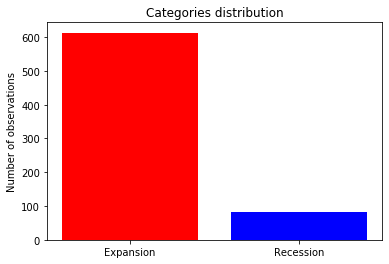

In [38]:
bars = ('Expansion', 'Recession')
y_pos = np.arange(len(bars))
height = df_m['USREC'].value_counts()


plt.bar(y_pos, height, color=['red', 'blue'])
plt.xticks(y_pos, bars)
plt.title('Categories distribution')
plt.ylabel('Number of observations')
plt.savefig('Monthly_Categories.png')
plt.show()

# Defining functions

In [25]:
def QPS(prediction_probability, Truth):
    '''Quadratic Probability Score calculator'''
    qps_lst = []
    for i in range(len(prediction_probability)):
        qps_lst.append(2*(prediction_probability[i] - Truth[i])**2)
    qps_sum = sum(qps_lst)
    return (qps_sum/len(prediction_probability))

def error_metrics(yprob, ypred, ytest):
    error_lst = [QPS(yprob, ytest),
                 log_loss(ytest, yprob), 
                 accuracy_score(ytest, ypred),
                 recall_score(ytest,ypred),
                 confusion_matrix(ytest, ypred)[0, 1],
                 confusion_matrix(ytest, ypred)[1, 0]
                ]
    return error_lst

# Model 1 - Monthly trainCVsplit with MultipleOutput

In [20]:
#I need the index to be a datetime object
df_m.index = pd.to_datetime(df_m.index)

y_m_all_tcis = df_m[m_hrz_lst]
y_m_all_tcis = y_m.dropna()
x_m_all_tcis = df_m.drop(columns = m_hrz_lst)
x_m_all_tcis = x_m_all_tcis[:y_m_all_tcis.shape[0]]

n_splits = len(x_m_all_tcis)-2
#Number of train/cv/test folds
#58 or 57 is the number for annual splits more or less

trainTestSplit = TimeSeriesSplit(n_splits+1).split(x_m_all_tcis)
for i in range(28*12):
    next(trainTestSplit)#Skip the first fold

rmse_m_all_tcis = []
loss_m_all_tcis = []
predicted_m_all_tcis = np.array([])
pred_proba_m_all_tcis = np.array([])

for trainCvIndices, testIndices in trainTestSplit:
    # First, we split Train + CV and Test
    XTrainCv, yTrainCv = x_m_all_tcis.iloc[trainCvIndices,0:], y_m_all_tcis.iloc[trainCvIndices,0:]
    XTest, yTest       = x_m_all_tcis.iloc[testIndices,0:]   , y_m_all_tcis.iloc[testIndices,0:]
    
    # Then, we build a list of the form [ ( [...Train Indices...], [...CV Indices...]  )]
    testLength = len(XTest)
    tcis = [(list(range(trainCvIndices[0],trainCvIndices[-testLength])),
                     list(range(trainCvIndices[-testLength],trainCvIndices[-1]+1)))]
    
    #Model construction and wrapper
    model_m_all_tcis = LogisticRegressionCV(
            Cs = 100,
            penalty = 'l1',
            solver = 'saga',
            cv = tcis,
            max_iter = 10000,
            tol = 1e-3,
            n_jobs = -1,
            fit_intercept = True)
    wrapper = MultiOutputClassifier(model_m_all_tcis)
    wrapper.fit(XTrainCv, yTrainCv)
    
    #Probabilities and predictions
    ypredicted_m_all_tcis = wrapper.predict(XTest)
    ypred_proba_m_all_tcis =  wrapper.predict_proba(XTest)
    predicted_m_all_tcis = np.append(predicted_m_all_tcis, ypredicted_m_all_tcis)
    pred_proba_m_all_tcis = np.append(pred_proba_m_all_tcis, ypred_proba_m_all_tcis)

    # Printing date ranges
    print("Training:"           , XTrainCv.index[0].date(), "--", XTrainCv.index[-testLength-1].date(),
          ", Cv:"     , XTrainCv.index[-testLength].date(), "--", XTrainCv.index[-1].date(),
          ", Test:"                , XTest.index[0].date(), "--", XTest.index[-1].date())

Training: 1962-01-01 -- 1989-12-01 , Cv: 1990-01-01 -- 1990-01-01 , Test: 1990-02-01 -- 1990-02-01
Training: 1962-01-01 -- 1990-01-01 , Cv: 1990-02-01 -- 1990-02-01 , Test: 1990-03-01 -- 1990-03-01
Training: 1962-01-01 -- 1990-02-01 , Cv: 1990-03-01 -- 1990-03-01 , Test: 1990-04-01 -- 1990-04-01
Training: 1962-01-01 -- 1990-03-01 , Cv: 1990-04-01 -- 1990-04-01 , Test: 1990-05-01 -- 1990-05-01
Training: 1962-01-01 -- 1990-04-01 , Cv: 1990-05-01 -- 1990-05-01 , Test: 1990-06-01 -- 1990-06-01
Training: 1962-01-01 -- 1990-05-01 , Cv: 1990-06-01 -- 1990-06-01 , Test: 1990-07-01 -- 1990-07-01
Training: 1962-01-01 -- 1990-06-01 , Cv: 1990-07-01 -- 1990-07-01 , Test: 1990-08-01 -- 1990-08-01
Training: 1962-01-01 -- 1990-07-01 , Cv: 1990-08-01 -- 1990-08-01 , Test: 1990-09-01 -- 1990-09-01
Training: 1962-01-01 -- 1990-08-01 , Cv: 1990-09-01 -- 1990-09-01 , Test: 1990-10-01 -- 1990-10-01
Training: 1962-01-01 -- 1990-09-01 , Cv: 1990-10-01 -- 1990-10-01 , Test: 1990-11-01 -- 1990-11-01
Training: 

Training: 1962-01-01 -- 1996-11-01 , Cv: 1996-12-01 -- 1996-12-01 , Test: 1997-01-01 -- 1997-01-01
Training: 1962-01-01 -- 1996-12-01 , Cv: 1997-01-01 -- 1997-01-01 , Test: 1997-02-01 -- 1997-02-01
Training: 1962-01-01 -- 1997-01-01 , Cv: 1997-02-01 -- 1997-02-01 , Test: 1997-03-01 -- 1997-03-01
Training: 1962-01-01 -- 1997-02-01 , Cv: 1997-03-01 -- 1997-03-01 , Test: 1997-04-01 -- 1997-04-01
Training: 1962-01-01 -- 1997-03-01 , Cv: 1997-04-01 -- 1997-04-01 , Test: 1997-05-01 -- 1997-05-01
Training: 1962-01-01 -- 1997-04-01 , Cv: 1997-05-01 -- 1997-05-01 , Test: 1997-06-01 -- 1997-06-01
Training: 1962-01-01 -- 1997-05-01 , Cv: 1997-06-01 -- 1997-06-01 , Test: 1997-07-01 -- 1997-07-01
Training: 1962-01-01 -- 1997-06-01 , Cv: 1997-07-01 -- 1997-07-01 , Test: 1997-08-01 -- 1997-08-01
Training: 1962-01-01 -- 1997-07-01 , Cv: 1997-08-01 -- 1997-08-01 , Test: 1997-09-01 -- 1997-09-01
Training: 1962-01-01 -- 1997-08-01 , Cv: 1997-09-01 -- 1997-09-01 , Test: 1997-10-01 -- 1997-10-01
Training: 

Training: 1962-01-01 -- 2003-10-01 , Cv: 2003-11-01 -- 2003-11-01 , Test: 2003-12-01 -- 2003-12-01
Training: 1962-01-01 -- 2003-11-01 , Cv: 2003-12-01 -- 2003-12-01 , Test: 2004-01-01 -- 2004-01-01
Training: 1962-01-01 -- 2003-12-01 , Cv: 2004-01-01 -- 2004-01-01 , Test: 2004-02-01 -- 2004-02-01
Training: 1962-01-01 -- 2004-01-01 , Cv: 2004-02-01 -- 2004-02-01 , Test: 2004-03-01 -- 2004-03-01
Training: 1962-01-01 -- 2004-02-01 , Cv: 2004-03-01 -- 2004-03-01 , Test: 2004-04-01 -- 2004-04-01
Training: 1962-01-01 -- 2004-03-01 , Cv: 2004-04-01 -- 2004-04-01 , Test: 2004-05-01 -- 2004-05-01
Training: 1962-01-01 -- 2004-04-01 , Cv: 2004-05-01 -- 2004-05-01 , Test: 2004-06-01 -- 2004-06-01
Training: 1962-01-01 -- 2004-05-01 , Cv: 2004-06-01 -- 2004-06-01 , Test: 2004-07-01 -- 2004-07-01
Training: 1962-01-01 -- 2004-06-01 , Cv: 2004-07-01 -- 2004-07-01 , Test: 2004-08-01 -- 2004-08-01
Training: 1962-01-01 -- 2004-07-01 , Cv: 2004-08-01 -- 2004-08-01 , Test: 2004-09-01 -- 2004-09-01
Training: 

Training: 1962-01-01 -- 2010-09-01 , Cv: 2010-10-01 -- 2010-10-01 , Test: 2010-11-01 -- 2010-11-01
Training: 1962-01-01 -- 2010-10-01 , Cv: 2010-11-01 -- 2010-11-01 , Test: 2010-12-01 -- 2010-12-01
Training: 1962-01-01 -- 2010-11-01 , Cv: 2010-12-01 -- 2010-12-01 , Test: 2011-01-01 -- 2011-01-01
Training: 1962-01-01 -- 2010-12-01 , Cv: 2011-01-01 -- 2011-01-01 , Test: 2011-02-01 -- 2011-02-01
Training: 1962-01-01 -- 2011-01-01 , Cv: 2011-02-01 -- 2011-02-01 , Test: 2011-03-01 -- 2011-03-01
Training: 1962-01-01 -- 2011-02-01 , Cv: 2011-03-01 -- 2011-03-01 , Test: 2011-04-01 -- 2011-04-01
Training: 1962-01-01 -- 2011-03-01 , Cv: 2011-04-01 -- 2011-04-01 , Test: 2011-05-01 -- 2011-05-01
Training: 1962-01-01 -- 2011-04-01 , Cv: 2011-05-01 -- 2011-05-01 , Test: 2011-06-01 -- 2011-06-01
Training: 1962-01-01 -- 2011-05-01 , Cv: 2011-06-01 -- 2011-06-01 , Test: 2011-07-01 -- 2011-07-01
Training: 1962-01-01 -- 2011-06-01 , Cv: 2011-07-01 -- 2011-07-01 , Test: 2011-08-01 -- 2011-08-01
Training: 

Training: 1962-01-01 -- 2017-08-01 , Cv: 2017-09-01 -- 2017-09-01 , Test: 2017-10-01 -- 2017-10-01
Training: 1962-01-01 -- 2017-09-01 , Cv: 2017-10-01 -- 2017-10-01 , Test: 2017-11-01 -- 2017-11-01
Training: 1962-01-01 -- 2017-10-01 , Cv: 2017-11-01 -- 2017-11-01 , Test: 2017-12-01 -- 2017-12-01
Training: 1962-01-01 -- 2017-11-01 , Cv: 2017-12-01 -- 2017-12-01 , Test: 2018-01-01 -- 2018-01-01
Training: 1962-01-01 -- 2017-12-01 , Cv: 2018-01-01 -- 2018-01-01 , Test: 2018-02-01 -- 2018-02-01
Training: 1962-01-01 -- 2018-01-01 , Cv: 2018-02-01 -- 2018-02-01 , Test: 2018-03-01 -- 2018-03-01
Training: 1962-01-01 -- 2018-02-01 , Cv: 2018-03-01 -- 2018-03-01 , Test: 2018-04-01 -- 2018-04-01
Training: 1962-01-01 -- 2018-03-01 , Cv: 2018-04-01 -- 2018-04-01 , Test: 2018-05-01 -- 2018-05-01
Training: 1962-01-01 -- 2018-04-01 , Cv: 2018-05-01 -- 2018-05-01 , Test: 2018-06-01 -- 2018-06-01
Training: 1962-01-01 -- 2018-05-01 , Cv: 2018-06-01 -- 2018-06-01 , Test: 2018-07-01 -- 2018-07-01
Training: 

# Predicting errors

In [28]:
#Uncomment below when needed
# pred_proba_m_all_tcis = pred_proba_m_all_tcis.tolist()
# predicted_m_all_tcis = predicted_m_all_tcis.tolist()

pred_proba_lst_0 = pred_proba_m_all_tcis[1::12]
predicted_lst_0 = predicted_m_all_tcis[0::6]
yTest_m0 = df_m['USREC']['1990-02-01':'2018-12-01']
errors_0 = error_metrics(pred_proba_lst_0, predicted_lst_0, yTest_m0)

pred_proba_lst_1 = pred_proba_m_all_tcis[3::12]
predicted_lst_1 = predicted_m_all_tcis[1::6]
yTest_m1 = df_m['USREC+1']['1990-02-01':'2018-12-01']
errors_1 = error_metrics(pred_proba_lst_1, predicted_lst_1, yTest_m1)

pred_proba_lst_3 = pred_proba_m_all_tcis[5::12]
predicted_lst_3 = predicted_m_all_tcis[2::6]
yTest_m3 = df_m['USREC+3']['1990-02-01':'2018-12-01']
errors_3 = error_metrics(pred_proba_lst_3, predicted_lst_3, yTest_m3)

pred_proba_lst_6 = pred_proba_m_all_tcis[7::12]
predicted_lst_6 = predicted_m_all_tcis[3::6]
yTest_m6 = df_m['USREC+6']['1990-02-01':'2018-12-01']
errors_6 = error_metrics(pred_proba_lst_6, predicted_lst_6, yTest_m6)

pred_proba_lst_9 = pred_proba_m_all_tcis[9::12]
predicted_lst_9 = predicted_m_all_tcis[4::6]
yTest_m9 = df_m['USREC+9']['1990-02-01':'2018-12-01']
errors_9 = error_metrics(pred_proba_lst_9, predicted_lst_9, yTest_m9)

pred_proba_lst_12 = pred_proba_m_all_tcis[11::12]
predicted_lst_12 = predicted_m_all_tcis[5::6] 
yTest_m12 = df_m['USREC+12']['1990-02-01':'2018-12-01']
errors_12 = error_metrics(pred_proba_lst_12, predicted_lst_12, yTest_m12)
errors_tcis_all = pd.DataFrame(data = [errors_0,
                                        errors_3,
                                        errors_6,
                                        errors_9,
                                        errors_12],
                                 index = ['hrz_0',
                                         'hrz_3',
                                         'hrz_6',
                                         'hrz_9',
                                         'hrz_12'],
                                columns = ['QPS', 'LogLoss', 'Accuracy',
                                           'Sensitivity', 'False Positives', 
                                           'False Negatives'])


errors_tcis_all

,QPS,LogLoss,Accuracy,Sensitivity,False Positives,False Negatives
hrz_0,0.099144,0.221543,0.968300,0.764706,3,8
hrz_3,0.117198,0.264280,0.936599,0.411765,2,20
hrz_6,0.140130,0.275449,0.927954,0.294118,1,24
hrz_9,0.144356,0.285472,0.925072,0.225806,2,24
hrz_12,0.134005,0.267977,0.933718,0.250000,2,21


# Model 2 - Monthly tscv with MultipleOutput 

In [23]:
#I need the index to be a datetime object
df_m.index = pd.to_datetime(df_m.index)

y_m_all_tscv = df_m[m_hrz_lst]
y_m_all_tscv = y_m.dropna()
x_m_all_tscv = df_m.drop(columns = m_hrz_lst)
x_m_all_tscv = x_m_all_tscv[:y_m_all_tscv.shape[0]]

n_splits = len(x_m_all_tscv)-2
#Number of train/cv/test folds
#58 or 57 is the number for annual splits more or less

trainTestSplit = TimeSeriesSplit(n_splits+1).split(x_m_all_tscv)
for i in range(28*12):
    next(trainTestSplit)#Skip the first fold

rmse_m_all_tscv = []
loss_m_all_tscv = []
predicted_m_all_tscv = np.array([])
pred_proba_m_all_tscv = np.array([])

for trainCvIndices, testIndices in trainTestSplit:
    # First, we split Train + CV and Test
    XTrainCv, yTrainCv = x_m_all_tscv.iloc[trainCvIndices,0:], y_m_all_tscv.iloc[trainCvIndices,0:]
    XTest, yTest       = x_m_all_tscv.iloc[testIndices,0:]   , y_m_all_tscv.iloc[testIndices,0:]
    
    # Then, we build a list of the form [ ( [...Train Indices...], [...CV Indices...]  )]
    testLength = len(XTest)
    
    # Cross validation split
    tscv = TimeSeriesSplit(n_splits = 10).split(XTrainCv, y = yTrainCv)
    for i in range(1): #Skip first fold because no recessions
        next(tscv)
    
    #Model construction and wrapper
    #Need to use list(tscv) becasue not possible to pickle generators
    model_m_all_tscv = LogisticRegressionCV(
            Cs = 100,
            penalty = 'l1',
            solver = 'saga',
            cv = list(tscv),
            max_iter = 10000,
            tol = 1e-3,
            n_jobs = 1,
            fit_intercept = True)
    wrapper = MultiOutputClassifier(model_m_all_tscv)
    wrapper.fit(XTrainCv, yTrainCv)
    
    #Probabilities and predictions
    ypredicted_m_all_tscv = wrapper.predict(XTest)
    ypred_proba_m_all_tscv =  wrapper.predict_proba(XTest)
    predicted_m_all_tscv = np.append(predicted_m_all_tscv, ypredicted_m_all_tscv)
    pred_proba_m_all_tscv = np.append(pred_proba_m_all_tscv, ypred_proba_m_all_tscv)
    
    # Printing date ranges
    print("Training:"           , XTrainCv.index[0].date(), "--", XTrainCv.index[-testLength-1].date(),
          ", Cv:"     , XTrainCv.index[-testLength].date(), "--", XTrainCv.index[-1].date(),
          ", Test:"                , XTest.index[0].date(), "--", XTest.index[-1].date())

Training: 1962-01-01 -- 1989-12-01 , Cv: 1990-01-01 -- 1990-01-01 , Test: 1990-02-01 -- 1990-02-01
Training: 1962-01-01 -- 1990-01-01 , Cv: 1990-02-01 -- 1990-02-01 , Test: 1990-03-01 -- 1990-03-01
Training: 1962-01-01 -- 1990-02-01 , Cv: 1990-03-01 -- 1990-03-01 , Test: 1990-04-01 -- 1990-04-01
Training: 1962-01-01 -- 1990-03-01 , Cv: 1990-04-01 -- 1990-04-01 , Test: 1990-05-01 -- 1990-05-01
Training: 1962-01-01 -- 1990-04-01 , Cv: 1990-05-01 -- 1990-05-01 , Test: 1990-06-01 -- 1990-06-01
Training: 1962-01-01 -- 1990-05-01 , Cv: 1990-06-01 -- 1990-06-01 , Test: 1990-07-01 -- 1990-07-01
Training: 1962-01-01 -- 1990-06-01 , Cv: 1990-07-01 -- 1990-07-01 , Test: 1990-08-01 -- 1990-08-01
Training: 1962-01-01 -- 1990-07-01 , Cv: 1990-08-01 -- 1990-08-01 , Test: 1990-09-01 -- 1990-09-01
Training: 1962-01-01 -- 1990-08-01 , Cv: 1990-09-01 -- 1990-09-01 , Test: 1990-10-01 -- 1990-10-01
Training: 1962-01-01 -- 1990-09-01 , Cv: 1990-10-01 -- 1990-10-01 , Test: 1990-11-01 -- 1990-11-01
Training: 

Training: 1962-01-01 -- 1996-11-01 , Cv: 1996-12-01 -- 1996-12-01 , Test: 1997-01-01 -- 1997-01-01
Training: 1962-01-01 -- 1996-12-01 , Cv: 1997-01-01 -- 1997-01-01 , Test: 1997-02-01 -- 1997-02-01
Training: 1962-01-01 -- 1997-01-01 , Cv: 1997-02-01 -- 1997-02-01 , Test: 1997-03-01 -- 1997-03-01
Training: 1962-01-01 -- 1997-02-01 , Cv: 1997-03-01 -- 1997-03-01 , Test: 1997-04-01 -- 1997-04-01
Training: 1962-01-01 -- 1997-03-01 , Cv: 1997-04-01 -- 1997-04-01 , Test: 1997-05-01 -- 1997-05-01
Training: 1962-01-01 -- 1997-04-01 , Cv: 1997-05-01 -- 1997-05-01 , Test: 1997-06-01 -- 1997-06-01
Training: 1962-01-01 -- 1997-05-01 , Cv: 1997-06-01 -- 1997-06-01 , Test: 1997-07-01 -- 1997-07-01
Training: 1962-01-01 -- 1997-06-01 , Cv: 1997-07-01 -- 1997-07-01 , Test: 1997-08-01 -- 1997-08-01
Training: 1962-01-01 -- 1997-07-01 , Cv: 1997-08-01 -- 1997-08-01 , Test: 1997-09-01 -- 1997-09-01
Training: 1962-01-01 -- 1997-08-01 , Cv: 1997-09-01 -- 1997-09-01 , Test: 1997-10-01 -- 1997-10-01
Training: 

Training: 1962-01-01 -- 2003-10-01 , Cv: 2003-11-01 -- 2003-11-01 , Test: 2003-12-01 -- 2003-12-01
Training: 1962-01-01 -- 2003-11-01 , Cv: 2003-12-01 -- 2003-12-01 , Test: 2004-01-01 -- 2004-01-01
Training: 1962-01-01 -- 2003-12-01 , Cv: 2004-01-01 -- 2004-01-01 , Test: 2004-02-01 -- 2004-02-01
Training: 1962-01-01 -- 2004-01-01 , Cv: 2004-02-01 -- 2004-02-01 , Test: 2004-03-01 -- 2004-03-01
Training: 1962-01-01 -- 2004-02-01 , Cv: 2004-03-01 -- 2004-03-01 , Test: 2004-04-01 -- 2004-04-01
Training: 1962-01-01 -- 2004-03-01 , Cv: 2004-04-01 -- 2004-04-01 , Test: 2004-05-01 -- 2004-05-01
Training: 1962-01-01 -- 2004-04-01 , Cv: 2004-05-01 -- 2004-05-01 , Test: 2004-06-01 -- 2004-06-01
Training: 1962-01-01 -- 2004-05-01 , Cv: 2004-06-01 -- 2004-06-01 , Test: 2004-07-01 -- 2004-07-01
Training: 1962-01-01 -- 2004-06-01 , Cv: 2004-07-01 -- 2004-07-01 , Test: 2004-08-01 -- 2004-08-01
Training: 1962-01-01 -- 2004-07-01 , Cv: 2004-08-01 -- 2004-08-01 , Test: 2004-09-01 -- 2004-09-01
Training: 

Training: 1962-01-01 -- 2010-09-01 , Cv: 2010-10-01 -- 2010-10-01 , Test: 2010-11-01 -- 2010-11-01
Training: 1962-01-01 -- 2010-10-01 , Cv: 2010-11-01 -- 2010-11-01 , Test: 2010-12-01 -- 2010-12-01
Training: 1962-01-01 -- 2010-11-01 , Cv: 2010-12-01 -- 2010-12-01 , Test: 2011-01-01 -- 2011-01-01
Training: 1962-01-01 -- 2010-12-01 , Cv: 2011-01-01 -- 2011-01-01 , Test: 2011-02-01 -- 2011-02-01
Training: 1962-01-01 -- 2011-01-01 , Cv: 2011-02-01 -- 2011-02-01 , Test: 2011-03-01 -- 2011-03-01
Training: 1962-01-01 -- 2011-02-01 , Cv: 2011-03-01 -- 2011-03-01 , Test: 2011-04-01 -- 2011-04-01
Training: 1962-01-01 -- 2011-03-01 , Cv: 2011-04-01 -- 2011-04-01 , Test: 2011-05-01 -- 2011-05-01
Training: 1962-01-01 -- 2011-04-01 , Cv: 2011-05-01 -- 2011-05-01 , Test: 2011-06-01 -- 2011-06-01
Training: 1962-01-01 -- 2011-05-01 , Cv: 2011-06-01 -- 2011-06-01 , Test: 2011-07-01 -- 2011-07-01
Training: 1962-01-01 -- 2011-06-01 , Cv: 2011-07-01 -- 2011-07-01 , Test: 2011-08-01 -- 2011-08-01
Training: 

Training: 1962-01-01 -- 2017-08-01 , Cv: 2017-09-01 -- 2017-09-01 , Test: 2017-10-01 -- 2017-10-01
Training: 1962-01-01 -- 2017-09-01 , Cv: 2017-10-01 -- 2017-10-01 , Test: 2017-11-01 -- 2017-11-01
Training: 1962-01-01 -- 2017-10-01 , Cv: 2017-11-01 -- 2017-11-01 , Test: 2017-12-01 -- 2017-12-01
Training: 1962-01-01 -- 2017-11-01 , Cv: 2017-12-01 -- 2017-12-01 , Test: 2018-01-01 -- 2018-01-01
Training: 1962-01-01 -- 2017-12-01 , Cv: 2018-01-01 -- 2018-01-01 , Test: 2018-02-01 -- 2018-02-01
Training: 1962-01-01 -- 2018-01-01 , Cv: 2018-02-01 -- 2018-02-01 , Test: 2018-03-01 -- 2018-03-01
Training: 1962-01-01 -- 2018-02-01 , Cv: 2018-03-01 -- 2018-03-01 , Test: 2018-04-01 -- 2018-04-01
Training: 1962-01-01 -- 2018-03-01 , Cv: 2018-04-01 -- 2018-04-01 , Test: 2018-05-01 -- 2018-05-01
Training: 1962-01-01 -- 2018-04-01 , Cv: 2018-05-01 -- 2018-05-01 , Test: 2018-06-01 -- 2018-06-01
Training: 1962-01-01 -- 2018-05-01 , Cv: 2018-06-01 -- 2018-06-01 , Test: 2018-07-01 -- 2018-07-01
Training: 

# Predicting errors

In [67]:
#Uncomment below when needed
# pred_proba_m_all_tscv = pred_proba_m_all_tscv.tolist()
# predicted_m_all_tscv = predicted_m_all_tscv.tolist()

pred_proba_lst_0 = pred_proba_m_all_tscv[1::12]
predicted_lst_0 = predicted_m_all_tscv[0::6]
yTest_m0 = df_m['USREC']['1990-02-01':'2018-12-01']
errors_0 = error_metrics(pred_proba_lst_0, predicted_lst_0, yTest_m0)

pred_proba_lst_1 = pred_proba_m_all_tscv[3::12]
predicted_lst_1 = predicted_m_all_tscv[1::6]
yTest_m1 = df_m['USREC+1']['1990-02-01':'2018-12-01']
errors_1 = error_metrics(pred_proba_lst_1, predicted_lst_1, yTest_m1)

pred_proba_lst_3 = pred_proba_m_all_tscv[5::12]
predicted_lst_3 = predicted_m_all_tscv[2::6]
yTest_m3 = df_m['USREC+3']['1990-02-01':'2018-12-01']
errors_3 = error_metrics(pred_proba_lst_3, predicted_lst_3, yTest_m3)

pred_proba_lst_6 = pred_proba_m_all_tscv[7::12]
predicted_lst_6 = predicted_m_all_tscv[3::6]
yTest_m6 = df_m['USREC+6']['1990-02-01':'2018-12-01']
errors_6 = error_metrics(pred_proba_lst_6, predicted_lst_6, yTest_m6)

pred_proba_lst_9 = pred_proba_m_all_tscv[9::12]
predicted_lst_9 = predicted_m_all_tscv[4::6]
yTest_m9 = df_m['USREC+9']['1990-02-01':'2018-12-01']
errors_9 = error_metrics(pred_proba_lst_9, predicted_lst_9, yTest_m9)

pred_proba_lst_12 = pred_proba_m_all_tscv[11::12]
predicted_lst_12 = predicted_m_all_tscv[5::6] 
yTest_m12 = df_m['USREC+12']['1990-02-01':'2018-12-01']
errors_12 = error_metrics(pred_proba_lst_12, predicted_lst_12, yTest_m12)
errors_tscv_all = pd.DataFrame(data = [errors_0,
                                        errors_3,
                                        errors_6,
                                        errors_9,
                                        errors_12],
                                 index = ['hrz_0',
                                         'hrz_3',
                                         'hrz_6',
                                         'hrz_9',
                                         'hrz_12'],
                                columns = ['QPS', 'LogLoss', 'Accuracy',
                                           'Sensitivity', 'False Positives', 
                                           'False Negatives'])


errors_tscv_all

,QPS,LogLoss,Accuracy,Sensitivity,False Positives,False Negatives
hrz_0,0.056963,0.109837,0.959654,0.647059,2,12
hrz_3,0.102512,0.203227,0.933718,0.500000,6,17
hrz_6,0.121361,0.226909,0.925072,0.235294,0,26
hrz_9,0.117690,0.183779,0.916427,0.096774,1,28
hrz_12,0.108121,0.178051,0.927954,0.250000,4,21


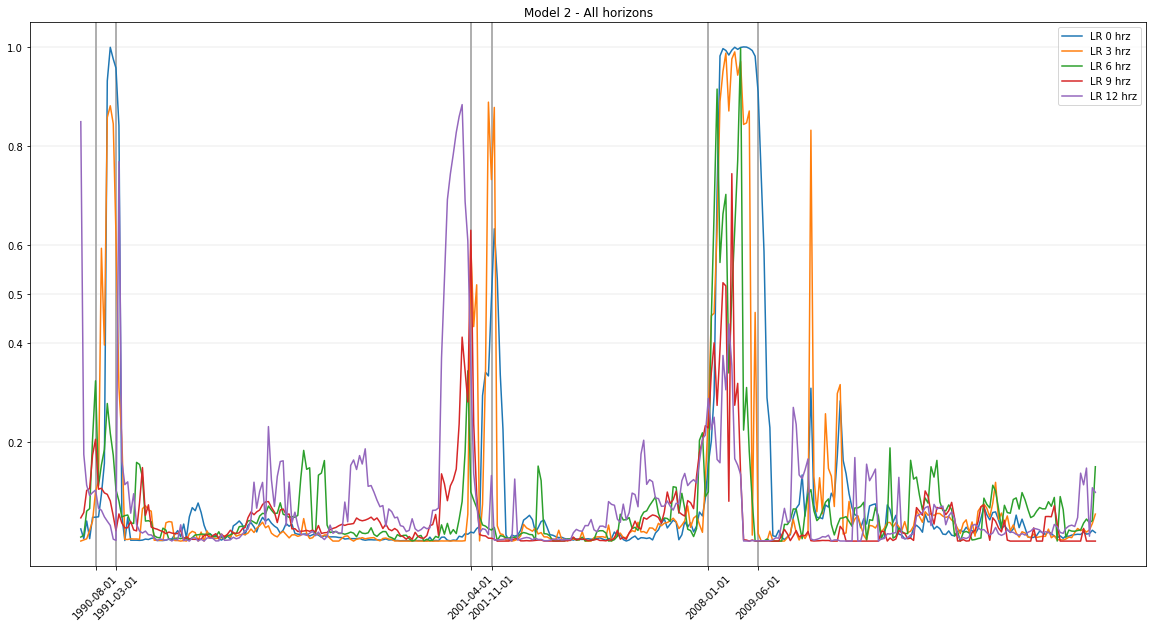

In [68]:
from datetime import datetime
from dateutil.parser import parse

testdates_m_all_tscv = pd.date_range(start = "1990-02-01",
                          end = "2019-01-01",
                         freq = 'M')
recession_dates = ['1990-08-01',
                '1991-03-01',
                '2001-04-01',
                '2001-11-01',
                '2008-01-01',
                '2009-06-01']
recession_dates_time = [datetime.strptime(x, '%Y-%m-%d') for x in recession_dates]

plt.figure(figsize=(20,10))
plt.plot(testdates_m_all_tscv, pred_proba_lst_0, label = 'LR 0 hrz')
plt.plot(testdates_m_all_tscv, pred_proba_lst_3, label = 'LR 3 hrz')
plt.plot(testdates_m_all_tscv, pred_proba_lst_6, label = 'LR 6 hrz')
plt.plot(testdates_m_all_tscv, pred_proba_lst_9, label = 'LR 9 hrz')
plt.plot(testdates_m_all_tscv, pred_proba_lst_12, label = 'LR 12 hrz')

plt.xticks(ticks = recession_dates_time, labels = recession_dates, rotation = 45)
plt.yticks(ticks = [0.2, 0.4, 0.5, 0.6, 0.8, 1])


plt.title('Model 2 - All horizons')
plt.grid(linewidth = 2, axis = 'x')
plt.grid(linestyle = '-', linewidth = 0.25, axis = 'y')
plt.legend()
plt.savefig('Model 2 - All horizons.png')
plt.show()

It seems that tscv is better across the board, with better QPS, LogLoss and comparable False Positive and False Negatives. Very good result in particular for the lag_12 which performs better than lag_6 and lag_9 in terms of QPS and LogLoss and also on the same level for False Positives and Negatives

# Model 3 - Monthly Train tscv with Classifier chain

In [40]:
#I need the index to be a datetime object
df_m.index = pd.to_datetime(df_m.index)

y_m_chain_tscv = df_m[m_hrz_lst]
y_m_chain_tscv = y_m.dropna()
x_m_chain_tscv = df_m.drop(columns = m_hrz_lst)
x_m_chain_tscv = x_m_chain_tscv[:y_m_chain_tscv.shape[0]]

n_splits = len(x_m_chain_tscv)-2
#Number of train/cv/test folds
#58 or 57 is the number for annual splits more or less

trainTestSplit = TimeSeriesSplit(n_splits+1).split(x_m_chain_tscv)
for i in range(28*12):
    next(trainTestSplit)#Skip the first fold

rmse_m_chain_tscv = []
loss_m_chain_tscv = []
predicted_m_chain_tscv = np.array([])
pred_proba_m_chain_tscv = np.array([])

for trainCvIndices, testIndices in trainTestSplit:
    # First, we split Train + CV and Test
    XTrainCv, yTrainCv = x_m_chain_tscv.iloc[trainCvIndices,0:], y_m_chain_tscv.iloc[trainCvIndices,0:]
    XTest, yTest       = x_m_chain_tscv.iloc[testIndices,0:]   , y_m_chain_tscv.iloc[testIndices,0:]
    
    # Then, we build a list of the form [ ( [...Train Indices...], [...CV Indices...]  )]
    testLength = len(XTest)
    
    # Cross validation split
    tscv = TimeSeriesSplit(n_splits = 10).split(XTrainCv, y = yTrainCv)
    for i in range(1): #Skip first fold because no recessions
        next(tscv)
    
    #Model construction and wrapper
    #Need to use list(tscv) becasue not possible to pickle generators
    model_m_chain_tscv = LogisticRegressionCV(
            Cs = 100,
            penalty = 'l1',
            solver = 'saga',
            cv = list(tscv),
            max_iter = 10000,
            tol = 1e-3,
            n_jobs = -1,
            fit_intercept = True)
    wrapper = ClassifierChain(model_m_chain_tscv)
    wrapper.fit(XTrainCv, yTrainCv)
    
    #Probabilities and predictions
    ypredicted_m_chain_tscv = wrapper.predict(XTest)
    ypred_proba_m_chain_tscv =  wrapper.predict_proba(XTest)
    predicted_m_chain_tscv = np.append(predicted_m_chain_tscv, ypredicted_m_chain_tscv)
    pred_proba_m_chain_tscv = np.append(pred_proba_m_chain_tscv, ypred_proba_m_chain_tscv)


    # Printing date ranges
    print("Training:"           , XTrainCv.index[0].date(), "--", XTrainCv.index[-testLength-1].date(),
          ", Cv:"     , XTrainCv.index[-testLength].date(), "--", XTrainCv.index[-1].date(),
          ", Test:"                , XTest.index[0].date(), "--", XTest.index[-1].date())


Training: 1962-01-01 -- 1989-12-01 , Cv: 1990-01-01 -- 1990-01-01 , Test: 1990-02-01 -- 1990-02-01
Training: 1962-01-01 -- 1990-01-01 , Cv: 1990-02-01 -- 1990-02-01 , Test: 1990-03-01 -- 1990-03-01
Training: 1962-01-01 -- 1990-02-01 , Cv: 1990-03-01 -- 1990-03-01 , Test: 1990-04-01 -- 1990-04-01
Training: 1962-01-01 -- 1990-03-01 , Cv: 1990-04-01 -- 1990-04-01 , Test: 1990-05-01 -- 1990-05-01
Training: 1962-01-01 -- 1990-04-01 , Cv: 1990-05-01 -- 1990-05-01 , Test: 1990-06-01 -- 1990-06-01
Training: 1962-01-01 -- 1990-05-01 , Cv: 1990-06-01 -- 1990-06-01 , Test: 1990-07-01 -- 1990-07-01
Training: 1962-01-01 -- 1990-06-01 , Cv: 1990-07-01 -- 1990-07-01 , Test: 1990-08-01 -- 1990-08-01
Training: 1962-01-01 -- 1990-07-01 , Cv: 1990-08-01 -- 1990-08-01 , Test: 1990-09-01 -- 1990-09-01
Training: 1962-01-01 -- 1990-08-01 , Cv: 1990-09-01 -- 1990-09-01 , Test: 1990-10-01 -- 1990-10-01
Training: 1962-01-01 -- 1990-09-01 , Cv: 1990-10-01 -- 1990-10-01 , Test: 1990-11-01 -- 1990-11-01
Training: 

Training: 1962-01-01 -- 1996-11-01 , Cv: 1996-12-01 -- 1996-12-01 , Test: 1997-01-01 -- 1997-01-01
Training: 1962-01-01 -- 1996-12-01 , Cv: 1997-01-01 -- 1997-01-01 , Test: 1997-02-01 -- 1997-02-01
Training: 1962-01-01 -- 1997-01-01 , Cv: 1997-02-01 -- 1997-02-01 , Test: 1997-03-01 -- 1997-03-01
Training: 1962-01-01 -- 1997-02-01 , Cv: 1997-03-01 -- 1997-03-01 , Test: 1997-04-01 -- 1997-04-01
Training: 1962-01-01 -- 1997-03-01 , Cv: 1997-04-01 -- 1997-04-01 , Test: 1997-05-01 -- 1997-05-01
Training: 1962-01-01 -- 1997-04-01 , Cv: 1997-05-01 -- 1997-05-01 , Test: 1997-06-01 -- 1997-06-01
Training: 1962-01-01 -- 1997-05-01 , Cv: 1997-06-01 -- 1997-06-01 , Test: 1997-07-01 -- 1997-07-01
Training: 1962-01-01 -- 1997-06-01 , Cv: 1997-07-01 -- 1997-07-01 , Test: 1997-08-01 -- 1997-08-01
Training: 1962-01-01 -- 1997-07-01 , Cv: 1997-08-01 -- 1997-08-01 , Test: 1997-09-01 -- 1997-09-01
Training: 1962-01-01 -- 1997-08-01 , Cv: 1997-09-01 -- 1997-09-01 , Test: 1997-10-01 -- 1997-10-01
Training: 

Training: 1962-01-01 -- 2003-10-01 , Cv: 2003-11-01 -- 2003-11-01 , Test: 2003-12-01 -- 2003-12-01
Training: 1962-01-01 -- 2003-11-01 , Cv: 2003-12-01 -- 2003-12-01 , Test: 2004-01-01 -- 2004-01-01
Training: 1962-01-01 -- 2003-12-01 , Cv: 2004-01-01 -- 2004-01-01 , Test: 2004-02-01 -- 2004-02-01
Training: 1962-01-01 -- 2004-01-01 , Cv: 2004-02-01 -- 2004-02-01 , Test: 2004-03-01 -- 2004-03-01
Training: 1962-01-01 -- 2004-02-01 , Cv: 2004-03-01 -- 2004-03-01 , Test: 2004-04-01 -- 2004-04-01
Training: 1962-01-01 -- 2004-03-01 , Cv: 2004-04-01 -- 2004-04-01 , Test: 2004-05-01 -- 2004-05-01
Training: 1962-01-01 -- 2004-04-01 , Cv: 2004-05-01 -- 2004-05-01 , Test: 2004-06-01 -- 2004-06-01
Training: 1962-01-01 -- 2004-05-01 , Cv: 2004-06-01 -- 2004-06-01 , Test: 2004-07-01 -- 2004-07-01
Training: 1962-01-01 -- 2004-06-01 , Cv: 2004-07-01 -- 2004-07-01 , Test: 2004-08-01 -- 2004-08-01
Training: 1962-01-01 -- 2004-07-01 , Cv: 2004-08-01 -- 2004-08-01 , Test: 2004-09-01 -- 2004-09-01
Training: 

Training: 1962-01-01 -- 2010-09-01 , Cv: 2010-10-01 -- 2010-10-01 , Test: 2010-11-01 -- 2010-11-01
Training: 1962-01-01 -- 2010-10-01 , Cv: 2010-11-01 -- 2010-11-01 , Test: 2010-12-01 -- 2010-12-01
Training: 1962-01-01 -- 2010-11-01 , Cv: 2010-12-01 -- 2010-12-01 , Test: 2011-01-01 -- 2011-01-01
Training: 1962-01-01 -- 2010-12-01 , Cv: 2011-01-01 -- 2011-01-01 , Test: 2011-02-01 -- 2011-02-01
Training: 1962-01-01 -- 2011-01-01 , Cv: 2011-02-01 -- 2011-02-01 , Test: 2011-03-01 -- 2011-03-01
Training: 1962-01-01 -- 2011-02-01 , Cv: 2011-03-01 -- 2011-03-01 , Test: 2011-04-01 -- 2011-04-01
Training: 1962-01-01 -- 2011-03-01 , Cv: 2011-04-01 -- 2011-04-01 , Test: 2011-05-01 -- 2011-05-01
Training: 1962-01-01 -- 2011-04-01 , Cv: 2011-05-01 -- 2011-05-01 , Test: 2011-06-01 -- 2011-06-01
Training: 1962-01-01 -- 2011-05-01 , Cv: 2011-06-01 -- 2011-06-01 , Test: 2011-07-01 -- 2011-07-01
Training: 1962-01-01 -- 2011-06-01 , Cv: 2011-07-01 -- 2011-07-01 , Test: 2011-08-01 -- 2011-08-01
Training: 

Training: 1962-01-01 -- 2017-08-01 , Cv: 2017-09-01 -- 2017-09-01 , Test: 2017-10-01 -- 2017-10-01
Training: 1962-01-01 -- 2017-09-01 , Cv: 2017-10-01 -- 2017-10-01 , Test: 2017-11-01 -- 2017-11-01
Training: 1962-01-01 -- 2017-10-01 , Cv: 2017-11-01 -- 2017-11-01 , Test: 2017-12-01 -- 2017-12-01
Training: 1962-01-01 -- 2017-11-01 , Cv: 2017-12-01 -- 2017-12-01 , Test: 2018-01-01 -- 2018-01-01
Training: 1962-01-01 -- 2017-12-01 , Cv: 2018-01-01 -- 2018-01-01 , Test: 2018-02-01 -- 2018-02-01
Training: 1962-01-01 -- 2018-01-01 , Cv: 2018-02-01 -- 2018-02-01 , Test: 2018-03-01 -- 2018-03-01
Training: 1962-01-01 -- 2018-02-01 , Cv: 2018-03-01 -- 2018-03-01 , Test: 2018-04-01 -- 2018-04-01
Training: 1962-01-01 -- 2018-03-01 , Cv: 2018-04-01 -- 2018-04-01 , Test: 2018-05-01 -- 2018-05-01
Training: 1962-01-01 -- 2018-04-01 , Cv: 2018-05-01 -- 2018-05-01 , Test: 2018-06-01 -- 2018-06-01
Training: 1962-01-01 -- 2018-05-01 , Cv: 2018-06-01 -- 2018-06-01 , Test: 2018-07-01 -- 2018-07-01
Training: 

# Predicting errors

In [56]:
#Uncomment below when needed
pred_proba_m_chain_tscv = pred_proba_m_chain_tscv.tolist()
predicted_m_chain_tscv = predicted_m_chain_tscv.tolist()

pred_proba_lst_0 = pred_proba_m_chain_tscv[0::6] #n.b with chain is only one probability
predicted_lst_0 = predicted_m_chain_tscv[0::6]
yTest_m0 = df_m['USREC']['1990-02-01':'2018-12-01']
errors_0 = error_metrics(pred_proba_lst_0, predicted_lst_0, yTest_m0)

pred_proba_lst_1 = pred_proba_m_chain_tscv[1::6]
predicted_lst_1 = predicted_m_chain_tscv[1::6]
yTest_m1 = df_m['USREC+1']['1990-02-01':'2018-12-01']
errors_1 = error_metrics(pred_proba_lst_1, predicted_lst_1, yTest_m1)

pred_proba_lst_3 = pred_proba_m_chain_tscv[2::6]
predicted_lst_3 = predicted_m_chain_tscv[2::6]
yTest_m3 = df_m['USREC+3']['1990-02-01':'2018-12-01']
errors_3 = error_metrics(pred_proba_lst_3, predicted_lst_3, yTest_m3)

pred_proba_lst_6 = pred_proba_m_chain_tscv[3::6]
predicted_lst_6 = predicted_m_chain_tscv[3::6]
yTest_m6 = df_m['USREC+6']['1990-02-01':'2018-12-01']
errors_6 = error_metrics(pred_proba_lst_6, predicted_lst_6, yTest_m6)

pred_proba_lst_9 = pred_proba_m_chain_tscv[4::6]
predicted_lst_9 = predicted_m_chain_tscv[4::6]
yTest_m9 = df_m['USREC+9']['1990-02-01':'2018-12-01']
errors_9 = error_metrics(pred_proba_lst_9, predicted_lst_9, yTest_m9)

pred_proba_lst_12 = pred_proba_m_chain_tscv[5::6]
predicted_lst_12 = predicted_m_chain_tscv[5::6] 
yTest_m12 = df_m['USREC+12']['1990-02-01':'2018-12-01']
errors_12 = error_metrics(pred_proba_lst_12, predicted_lst_12, yTest_m12)
errors_tscv_chain = pd.DataFrame(data = [errors_0,
                                        errors_3,
                                        errors_6,
                                        errors_9,
                                        errors_12],
                                 index = ['hrz_0',
                                         'hrz_3',
                                         'hrz_6',
                                         'hrz_9',
                                         'hrz_12'],
                                columns = ['QPS', 'LogLoss', 'Accuracy',
                                           'Sensitivity', 'False Positives', 
                                           'False Negatives'])


errors_tscv_chain

,QPS,LogLoss,Accuracy,Sensitivity,False Positives,False Negatives
hrz_0,0.056949,0.109842,0.959654,0.647059,2,12
hrz_3,0.131900,0.266133,0.927954,0.441176,6,19
hrz_6,0.145516,0.253569,0.913545,0.205882,3,27
hrz_9,0.147503,0.252476,0.904899,0.096774,5,28
hrz_12,0.140047,0.251673,0.922190,0.071429,1,26


# Plotting

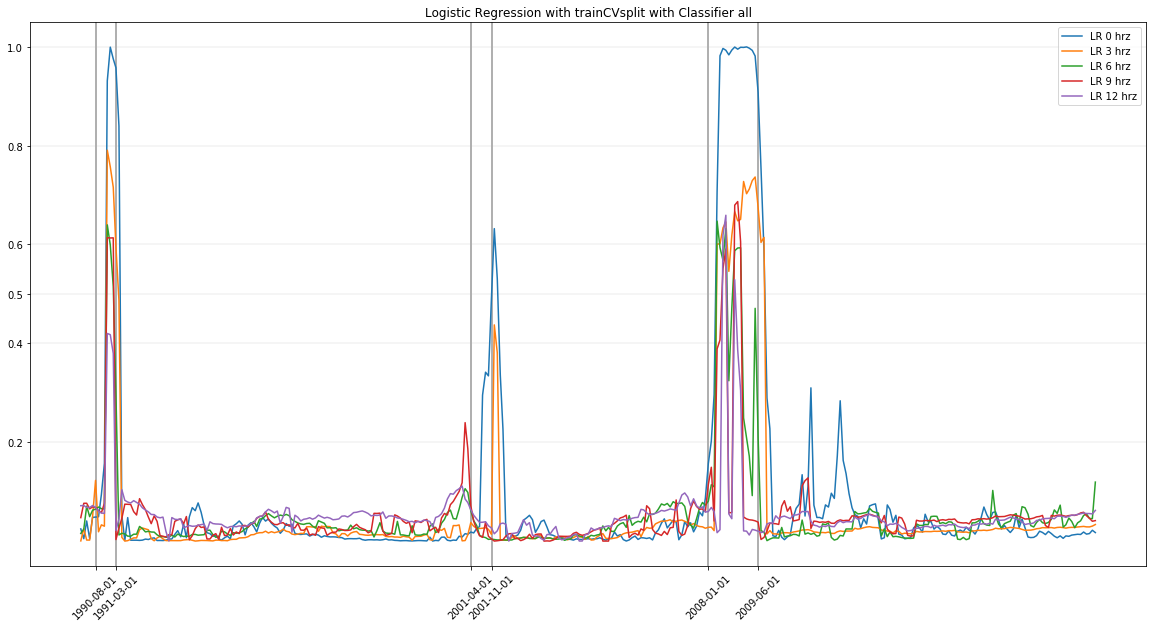

In [57]:
testdates_m_chain_tscv = pd.date_range(start = "1990-02-01",
                          end = "2019-01-01",
                         freq = 'M')
plt.figure(figsize=(20,10))
plt.plot(testdates_m_chain_tscv, pred_proba_lst_0, label = 'LR 0 hrz')
plt.plot(testdates_m_chain_tscv, pred_proba_lst_3, label = 'LR 3 hrz')
plt.plot(testdates_m_chain_tscv, pred_proba_lst_6, label = 'LR 6 hrz')
plt.plot(testdates_m_chain_tscv, pred_proba_lst_9, label = 'LR 9 hrz')
plt.plot(testdates_m_chain_tscv, pred_proba_lst_12, label = 'LR 12 hrz')

plt.xticks(ticks = recession_dates_time, labels = recession_dates, rotation = 45)
plt.yticks(ticks = [0.2, 0.4, 0.5, 0.6, 0.8, 1])


plt.title('Logistic Regression with trainCVsplit with Classifier all')
plt.grid(linewidth = 2, axis = 'x')
plt.grid(linestyle = '-', linewidth = 0.25, axis = 'y')
plt.legend()
plt.show()

The Classifier Chain has worse accuracy across the board, treating each prediction a independent produces better results. Also fromthe graph we can see that the predictions don't seem to be leading the recessions at all


# Model 4 - Model 2 using L2 penalty

In [43]:
#I need the index to be a datetime object
df_m.index = pd.to_datetime(df_m.index)

y_m_all_tscv_L2 = df_m[m_hrz_lst]
y_m_all_tscv_L2 = y_m.dropna()
x_m_all_tscv_L2 = df_m.drop(columns = m_hrz_lst)
x_m_all_tscv_L2 = x_m_all_tscv_L2[:y_m_all_tscv_L2.shape[0]]

n_splits = len(x_m_all_tscv_L2)-2
#Number of train/cv/test folds
#58 or 57 is the number for annual splits more or less

trainTestSplit = TimeSeriesSplit(n_splits+1).split(x_m_all_tscv_L2)
for i in range(28*12):
    next(trainTestSplit)#Skip the first fold

rmse_m_all_tscv_L2 = []
loss_m_all_tscv_L2 = []
predicted_m_all_tscv_L2 = np.array([])
pred_proba_m_all_tscv_L2 = np.array([])

for trainCvIndices, testIndices in trainTestSplit:
    # First, we split Train + CV and Test
    XTrainCv, yTrainCv = x_m_all_tscv_L2.iloc[trainCvIndices,0:], y_m_all_tscv_L2.iloc[trainCvIndices,0:]
    XTest, yTest       = x_m_all_tscv_L2.iloc[testIndices,0:]   , y_m_all_tscv_L2.iloc[testIndices,0:]
    
    # Then, we build a list of the form [ ( [...Train Indices...], [...CV Indices...]  )]
    testLength = len(XTest)
    
    # Cross validation split
    tscv_L2 = TimeSeriesSplit(n_splits = 10).split(XTrainCv, y = yTrainCv)
    for i in range(1): #Skip first fold because no recessions
        next(tscv_L2)
    
    #Model construction and wrapper
    #Need to use list(tscv_L2) becasue not possible to pickle generators
    model_m_all_tscv_L2 = LogisticRegressionCV(
            Cs = 100,
            penalty = 'l2',
            solver = 'saga',
            cv = list(tscv_L2),
            max_iter = 10000,
            tol = 1e-3,
            n_jobs = -1,
            fit_intercept = True)
    wrapper = MultiOutputClassifier(model_m_all_tscv_L2)
    wrapper.fit(XTrainCv, yTrainCv)
    
    #Probabilities and predictions
    ypredicted_m_all_tscv_L2 = wrapper.predict(XTest)
    ypred_proba_m_all_tscv_L2 =  wrapper.predict_proba(XTest)
    predicted_m_all_tscv_L2 = np.append(predicted_m_all_tscv_L2, ypredicted_m_all_tscv_L2)
    pred_proba_m_all_tscv_L2 = np.append(pred_proba_m_all_tscv_L2, ypred_proba_m_all_tscv_L2)
    
    # Printing date ranges
    print("Training:"           , XTrainCv.index[0].date(), "--", XTrainCv.index[-testLength-1].date(),
          ", Cv:"     , XTrainCv.index[-testLength].date(), "--", XTrainCv.index[-1].date(),
          ", Test:"                , XTest.index[0].date(), "--", XTest.index[-1].date())

Training: 1962-01-01 -- 1989-12-01 , Cv: 1990-01-01 -- 1990-01-01 , Test: 1990-02-01 -- 1990-02-01
Training: 1962-01-01 -- 1990-01-01 , Cv: 1990-02-01 -- 1990-02-01 , Test: 1990-03-01 -- 1990-03-01
Training: 1962-01-01 -- 1990-02-01 , Cv: 1990-03-01 -- 1990-03-01 , Test: 1990-04-01 -- 1990-04-01
Training: 1962-01-01 -- 1990-03-01 , Cv: 1990-04-01 -- 1990-04-01 , Test: 1990-05-01 -- 1990-05-01
Training: 1962-01-01 -- 1990-04-01 , Cv: 1990-05-01 -- 1990-05-01 , Test: 1990-06-01 -- 1990-06-01
Training: 1962-01-01 -- 1990-05-01 , Cv: 1990-06-01 -- 1990-06-01 , Test: 1990-07-01 -- 1990-07-01
Training: 1962-01-01 -- 1990-06-01 , Cv: 1990-07-01 -- 1990-07-01 , Test: 1990-08-01 -- 1990-08-01
Training: 1962-01-01 -- 1990-07-01 , Cv: 1990-08-01 -- 1990-08-01 , Test: 1990-09-01 -- 1990-09-01
Training: 1962-01-01 -- 1990-08-01 , Cv: 1990-09-01 -- 1990-09-01 , Test: 1990-10-01 -- 1990-10-01
Training: 1962-01-01 -- 1990-09-01 , Cv: 1990-10-01 -- 1990-10-01 , Test: 1990-11-01 -- 1990-11-01
Training: 

Training: 1962-01-01 -- 1996-11-01 , Cv: 1996-12-01 -- 1996-12-01 , Test: 1997-01-01 -- 1997-01-01
Training: 1962-01-01 -- 1996-12-01 , Cv: 1997-01-01 -- 1997-01-01 , Test: 1997-02-01 -- 1997-02-01
Training: 1962-01-01 -- 1997-01-01 , Cv: 1997-02-01 -- 1997-02-01 , Test: 1997-03-01 -- 1997-03-01
Training: 1962-01-01 -- 1997-02-01 , Cv: 1997-03-01 -- 1997-03-01 , Test: 1997-04-01 -- 1997-04-01
Training: 1962-01-01 -- 1997-03-01 , Cv: 1997-04-01 -- 1997-04-01 , Test: 1997-05-01 -- 1997-05-01
Training: 1962-01-01 -- 1997-04-01 , Cv: 1997-05-01 -- 1997-05-01 , Test: 1997-06-01 -- 1997-06-01
Training: 1962-01-01 -- 1997-05-01 , Cv: 1997-06-01 -- 1997-06-01 , Test: 1997-07-01 -- 1997-07-01
Training: 1962-01-01 -- 1997-06-01 , Cv: 1997-07-01 -- 1997-07-01 , Test: 1997-08-01 -- 1997-08-01
Training: 1962-01-01 -- 1997-07-01 , Cv: 1997-08-01 -- 1997-08-01 , Test: 1997-09-01 -- 1997-09-01
Training: 1962-01-01 -- 1997-08-01 , Cv: 1997-09-01 -- 1997-09-01 , Test: 1997-10-01 -- 1997-10-01
Training: 

Training: 1962-01-01 -- 2003-10-01 , Cv: 2003-11-01 -- 2003-11-01 , Test: 2003-12-01 -- 2003-12-01
Training: 1962-01-01 -- 2003-11-01 , Cv: 2003-12-01 -- 2003-12-01 , Test: 2004-01-01 -- 2004-01-01
Training: 1962-01-01 -- 2003-12-01 , Cv: 2004-01-01 -- 2004-01-01 , Test: 2004-02-01 -- 2004-02-01
Training: 1962-01-01 -- 2004-01-01 , Cv: 2004-02-01 -- 2004-02-01 , Test: 2004-03-01 -- 2004-03-01
Training: 1962-01-01 -- 2004-02-01 , Cv: 2004-03-01 -- 2004-03-01 , Test: 2004-04-01 -- 2004-04-01
Training: 1962-01-01 -- 2004-03-01 , Cv: 2004-04-01 -- 2004-04-01 , Test: 2004-05-01 -- 2004-05-01
Training: 1962-01-01 -- 2004-04-01 , Cv: 2004-05-01 -- 2004-05-01 , Test: 2004-06-01 -- 2004-06-01
Training: 1962-01-01 -- 2004-05-01 , Cv: 2004-06-01 -- 2004-06-01 , Test: 2004-07-01 -- 2004-07-01
Training: 1962-01-01 -- 2004-06-01 , Cv: 2004-07-01 -- 2004-07-01 , Test: 2004-08-01 -- 2004-08-01
Training: 1962-01-01 -- 2004-07-01 , Cv: 2004-08-01 -- 2004-08-01 , Test: 2004-09-01 -- 2004-09-01
Training: 

Training: 1962-01-01 -- 2010-09-01 , Cv: 2010-10-01 -- 2010-10-01 , Test: 2010-11-01 -- 2010-11-01
Training: 1962-01-01 -- 2010-10-01 , Cv: 2010-11-01 -- 2010-11-01 , Test: 2010-12-01 -- 2010-12-01
Training: 1962-01-01 -- 2010-11-01 , Cv: 2010-12-01 -- 2010-12-01 , Test: 2011-01-01 -- 2011-01-01
Training: 1962-01-01 -- 2010-12-01 , Cv: 2011-01-01 -- 2011-01-01 , Test: 2011-02-01 -- 2011-02-01
Training: 1962-01-01 -- 2011-01-01 , Cv: 2011-02-01 -- 2011-02-01 , Test: 2011-03-01 -- 2011-03-01
Training: 1962-01-01 -- 2011-02-01 , Cv: 2011-03-01 -- 2011-03-01 , Test: 2011-04-01 -- 2011-04-01
Training: 1962-01-01 -- 2011-03-01 , Cv: 2011-04-01 -- 2011-04-01 , Test: 2011-05-01 -- 2011-05-01
Training: 1962-01-01 -- 2011-04-01 , Cv: 2011-05-01 -- 2011-05-01 , Test: 2011-06-01 -- 2011-06-01
Training: 1962-01-01 -- 2011-05-01 , Cv: 2011-06-01 -- 2011-06-01 , Test: 2011-07-01 -- 2011-07-01
Training: 1962-01-01 -- 2011-06-01 , Cv: 2011-07-01 -- 2011-07-01 , Test: 2011-08-01 -- 2011-08-01
Training: 

Training: 1962-01-01 -- 2017-08-01 , Cv: 2017-09-01 -- 2017-09-01 , Test: 2017-10-01 -- 2017-10-01
Training: 1962-01-01 -- 2017-09-01 , Cv: 2017-10-01 -- 2017-10-01 , Test: 2017-11-01 -- 2017-11-01
Training: 1962-01-01 -- 2017-10-01 , Cv: 2017-11-01 -- 2017-11-01 , Test: 2017-12-01 -- 2017-12-01
Training: 1962-01-01 -- 2017-11-01 , Cv: 2017-12-01 -- 2017-12-01 , Test: 2018-01-01 -- 2018-01-01
Training: 1962-01-01 -- 2017-12-01 , Cv: 2018-01-01 -- 2018-01-01 , Test: 2018-02-01 -- 2018-02-01
Training: 1962-01-01 -- 2018-01-01 , Cv: 2018-02-01 -- 2018-02-01 , Test: 2018-03-01 -- 2018-03-01
Training: 1962-01-01 -- 2018-02-01 , Cv: 2018-03-01 -- 2018-03-01 , Test: 2018-04-01 -- 2018-04-01
Training: 1962-01-01 -- 2018-03-01 , Cv: 2018-04-01 -- 2018-04-01 , Test: 2018-05-01 -- 2018-05-01
Training: 1962-01-01 -- 2018-04-01 , Cv: 2018-05-01 -- 2018-05-01 , Test: 2018-06-01 -- 2018-06-01
Training: 1962-01-01 -- 2018-05-01 , Cv: 2018-06-01 -- 2018-06-01 , Test: 2018-07-01 -- 2018-07-01
Training: 

In [70]:
#Uncomment below when needed
# pred_proba_m_all_tscv_L2 = pred_proba_m_all_tscv_L2.tolist()
# predicted_m_all_tscv_L2 = predicted_m_all_tscv_L2.tolist()

pred_proba_lst_0 = pred_proba_m_all_tscv_L2[1::12]
predicted_lst_0 = predicted_m_all_tscv_L2[0::6]
yTest_m0 = df_m['USREC']['1990-02-01':'2018-12-01']
errors_0 = error_metrics(pred_proba_lst_0, predicted_lst_0, yTest_m0)

pred_proba_lst_1 = pred_proba_m_all_tscv_L2[3::12]
predicted_lst_1 = predicted_m_all_tscv_L2[1::6]
yTest_m1 = df_m['USREC+1']['1990-02-01':'2018-12-01']
errors_1 = error_metrics(pred_proba_lst_1, predicted_lst_1, yTest_m1)

pred_proba_lst_3 = pred_proba_m_all_tscv_L2[5::12]
predicted_lst_3 = predicted_m_all_tscv_L2[2::6]
yTest_m3 = df_m['USREC+3']['1990-02-01':'2018-12-01']
errors_3 = error_metrics(pred_proba_lst_3, predicted_lst_3, yTest_m3)

pred_proba_lst_6 = pred_proba_m_all_tscv_L2[7::12]
predicted_lst_6 = predicted_m_all_tscv_L2[3::6]
yTest_m6 = df_m['USREC+6']['1990-02-01':'2018-12-01']
errors_6 = error_metrics(pred_proba_lst_6, predicted_lst_6, yTest_m6)

pred_proba_lst_9 = pred_proba_m_all_tscv_L2[9::12]
predicted_lst_9 = predicted_m_all_tscv_L2[4::6]
yTest_m9 = df_m['USREC+9']['1990-02-01':'2018-12-01']
errors_9 = error_metrics(pred_proba_lst_9, predicted_lst_9, yTest_m9)

pred_proba_lst_12 = pred_proba_m_all_tscv_L2[11::12]
predicted_lst_12 = predicted_m_all_tscv_L2[5::6] 
yTest_m12 = df_m['USREC+12']['1990-02-01':'2018-12-01']
errors_12 = error_metrics(pred_proba_lst_12, predicted_lst_12, yTest_m12)
errors_tscv_L2_all = pd.DataFrame(data = [errors_0,
                                        errors_3,
                                        errors_6,
                                        errors_9,
                                        errors_12],
                                 index = ['hrz_0',
                                         'hrz_3',
                                         'hrz_6',
                                         'hrz_9',
                                         'hrz_12'],
                                columns = ['QPS', 'LogLoss', 'Accuracy',
                                           'Sensitivity', 'False Positives', 
                                           'False Negatives'])



errors_tscv_L2_all

,QPS,LogLoss,Accuracy,Sensitivity,False Positives,False Negatives
hrz_0,0.058890,0.114602,0.965418,0.705882,2,10
hrz_3,0.096467,0.177474,0.933718,0.441176,4,19
hrz_6,0.118933,0.212597,0.919308,0.235294,2,26
hrz_9,0.101401,0.163641,0.933718,0.322581,2,21
hrz_12,0.100146,0.156906,0.927954,0.250000,4,21


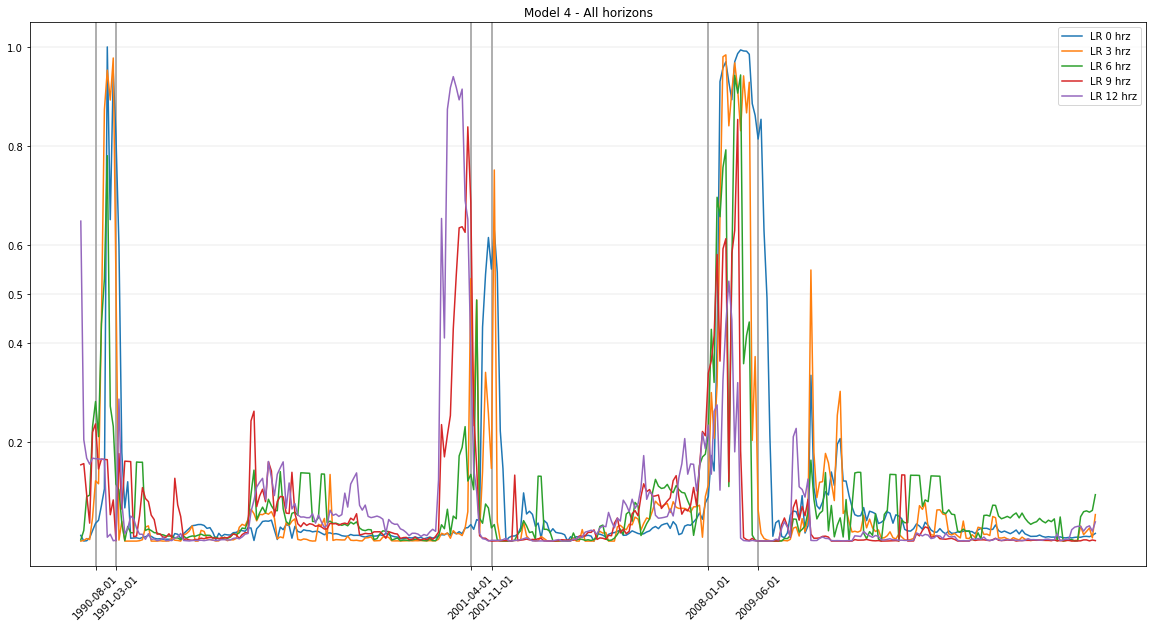

In [71]:
from datetime import datetime
from dateutil.parser import parse

testdates_m = pd.date_range(start = "1990-02-01",
                          end = "2019-01-01",
                         freq = 'M')
recession_dates = ['1990-08-01',
                '1991-03-01',
                '2001-04-01',
                '2001-11-01',
                '2008-01-01',
                '2009-06-01']
recession_dates_time = [datetime.strptime(x, '%Y-%m-%d') for x in recession_dates]

plt.figure(figsize=(20,10))
plt.plot(testdates_m, pred_proba_lst_0, label = 'LR 0 hrz')
plt.plot(testdates_m, pred_proba_lst_3, label = 'LR 3 hrz')
plt.plot(testdates_m, pred_proba_lst_6, label = 'LR 6 hrz')
plt.plot(testdates_m, pred_proba_lst_9, label = 'LR 9 hrz')
plt.plot(testdates_m, pred_proba_lst_12, label = 'LR 12 hrz')

plt.xticks(ticks = recession_dates_time, labels = recession_dates, rotation = 45)
plt.yticks(ticks = [0.2, 0.4, 0.5, 0.6, 0.8, 1])


plt.title('Model 4 - All horizons')
plt.grid(linewidth = 2, axis = 'x')
plt.grid(linestyle = '-', linewidth = 0.25, axis = 'y')
plt.legend()
plt.savefig('Model 4 - All horizons.png')
plt.show()

In [60]:
errors_tcis_all
#Actually very similar (L1 and L2)

,QPS,LogLoss,Accuracy,Sensitivity,False Positives,False Negatives
hrz_0,0.099144,0.221543,0.968300,0.764706,3,8
hrz_3,0.117198,0.264280,0.936599,0.411765,2,20
hrz_6,0.140130,0.275449,0.927954,0.294118,1,24
hrz_9,0.144356,0.285472,0.925072,0.225806,2,24
hrz_12,0.134005,0.267977,0.933718,0.250000,2,21


In [61]:
#Expereiment L2 with tcis

#I need the index to be a datetime object
df_m.index = pd.to_datetime(df_m.index)

y_m_all_tcis_L2 = df_m[m_hrz_lst]
y_m_all_tcis_L2 = y_m.dropna()
x_m_all_tcis_L2 = df_m.drop(columns = m_hrz_lst)
x_m_all_tcis_L2 = x_m_all_tcis_L2[:y_m_all_tcis_L2.shape[0]]

n_splits = len(x_m_all_tcis_L2)-2
#Number of train/cv/test folds
#58 or 57 is the number for annual splits more or less

trainTestSplit = TimeSeriesSplit(n_splits+1).split(x_m_all_tcis_L2)
for i in range(28*12):
    next(trainTestSplit)#Skip the first fold

rmse_m_all_tcis_L2 = []
loss_m_all_tcis_L2 = []
predicted_m_all_tcis_L2 = np.array([])
pred_proba_m_all_tcis_L2 = np.array([])

for trainCvIndices, testIndices in trainTestSplit:
    # First, we split Train + CV and Test
    XTrainCv, yTrainCv = x_m_all_tcis_L2.iloc[trainCvIndices,0:], y_m_all_tcis_L2.iloc[trainCvIndices,0:]
    XTest, yTest       = x_m_all_tcis_L2.iloc[testIndices,0:]   , y_m_all_tcis_L2.iloc[testIndices,0:]
    
    # Then, we build a list of the form [ ( [...Train Indices...], [...CV Indices...]  )]
    testLength = len(XTest)
    
    # Cross validation split
    tcis_L2 = [(list(range(trainCvIndices[0],trainCvIndices[-testLength])),
                     list(range(trainCvIndices[-testLength],trainCvIndices[-1]+1)))]
    
    #Model construction and wrapper
    #Need to use list(tcis_L2) becasue not possible to pickle generators
    model_m_all_tcis_L2 = LogisticRegressionCV(
            Cs = 100,
            penalty = 'l2',
            solver = 'saga',
            cv = list(tcis_L2),
            max_iter = 10000,
            tol = 1e-3,
            n_jobs = -1,
            fit_intercept = True)
    wrapper = MultiOutputClassifier(model_m_all_tcis_L2)
    wrapper.fit(XTrainCv, yTrainCv)
    
    #Probabilities and predictions
    ypredicted_m_all_tcis_L2 = wrapper.predict(XTest)
    ypred_proba_m_all_tcis_L2 =  wrapper.predict_proba(XTest)
    predicted_m_all_tcis_L2 = np.append(predicted_m_all_tcis_L2, ypredicted_m_all_tcis_L2)
    pred_proba_m_all_tcis_L2 = np.append(pred_proba_m_all_tcis_L2, ypred_proba_m_all_tcis_L2)
    
    # Printing date ranges
    print("Training:"           , XTrainCv.index[0].date(), "--", XTrainCv.index[-testLength-1].date(),
          ", Cv:"     , XTrainCv.index[-testLength].date(), "--", XTrainCv.index[-1].date(),
          ", Test:"                , XTest.index[0].date(), "--", XTest.index[-1].date())

Training: 1962-01-01 -- 1989-12-01 , Cv: 1990-01-01 -- 1990-01-01 , Test: 1990-02-01 -- 1990-02-01
Training: 1962-01-01 -- 1990-01-01 , Cv: 1990-02-01 -- 1990-02-01 , Test: 1990-03-01 -- 1990-03-01
Training: 1962-01-01 -- 1990-02-01 , Cv: 1990-03-01 -- 1990-03-01 , Test: 1990-04-01 -- 1990-04-01
Training: 1962-01-01 -- 1990-03-01 , Cv: 1990-04-01 -- 1990-04-01 , Test: 1990-05-01 -- 1990-05-01
Training: 1962-01-01 -- 1990-04-01 , Cv: 1990-05-01 -- 1990-05-01 , Test: 1990-06-01 -- 1990-06-01
Training: 1962-01-01 -- 1990-05-01 , Cv: 1990-06-01 -- 1990-06-01 , Test: 1990-07-01 -- 1990-07-01
Training: 1962-01-01 -- 1990-06-01 , Cv: 1990-07-01 -- 1990-07-01 , Test: 1990-08-01 -- 1990-08-01
Training: 1962-01-01 -- 1990-07-01 , Cv: 1990-08-01 -- 1990-08-01 , Test: 1990-09-01 -- 1990-09-01
Training: 1962-01-01 -- 1990-08-01 , Cv: 1990-09-01 -- 1990-09-01 , Test: 1990-10-01 -- 1990-10-01
Training: 1962-01-01 -- 1990-09-01 , Cv: 1990-10-01 -- 1990-10-01 , Test: 1990-11-01 -- 1990-11-01
Training: 

Training: 1962-01-01 -- 1996-11-01 , Cv: 1996-12-01 -- 1996-12-01 , Test: 1997-01-01 -- 1997-01-01
Training: 1962-01-01 -- 1996-12-01 , Cv: 1997-01-01 -- 1997-01-01 , Test: 1997-02-01 -- 1997-02-01
Training: 1962-01-01 -- 1997-01-01 , Cv: 1997-02-01 -- 1997-02-01 , Test: 1997-03-01 -- 1997-03-01
Training: 1962-01-01 -- 1997-02-01 , Cv: 1997-03-01 -- 1997-03-01 , Test: 1997-04-01 -- 1997-04-01
Training: 1962-01-01 -- 1997-03-01 , Cv: 1997-04-01 -- 1997-04-01 , Test: 1997-05-01 -- 1997-05-01
Training: 1962-01-01 -- 1997-04-01 , Cv: 1997-05-01 -- 1997-05-01 , Test: 1997-06-01 -- 1997-06-01
Training: 1962-01-01 -- 1997-05-01 , Cv: 1997-06-01 -- 1997-06-01 , Test: 1997-07-01 -- 1997-07-01
Training: 1962-01-01 -- 1997-06-01 , Cv: 1997-07-01 -- 1997-07-01 , Test: 1997-08-01 -- 1997-08-01
Training: 1962-01-01 -- 1997-07-01 , Cv: 1997-08-01 -- 1997-08-01 , Test: 1997-09-01 -- 1997-09-01
Training: 1962-01-01 -- 1997-08-01 , Cv: 1997-09-01 -- 1997-09-01 , Test: 1997-10-01 -- 1997-10-01
Training: 

Training: 1962-01-01 -- 2003-10-01 , Cv: 2003-11-01 -- 2003-11-01 , Test: 2003-12-01 -- 2003-12-01
Training: 1962-01-01 -- 2003-11-01 , Cv: 2003-12-01 -- 2003-12-01 , Test: 2004-01-01 -- 2004-01-01
Training: 1962-01-01 -- 2003-12-01 , Cv: 2004-01-01 -- 2004-01-01 , Test: 2004-02-01 -- 2004-02-01
Training: 1962-01-01 -- 2004-01-01 , Cv: 2004-02-01 -- 2004-02-01 , Test: 2004-03-01 -- 2004-03-01
Training: 1962-01-01 -- 2004-02-01 , Cv: 2004-03-01 -- 2004-03-01 , Test: 2004-04-01 -- 2004-04-01
Training: 1962-01-01 -- 2004-03-01 , Cv: 2004-04-01 -- 2004-04-01 , Test: 2004-05-01 -- 2004-05-01
Training: 1962-01-01 -- 2004-04-01 , Cv: 2004-05-01 -- 2004-05-01 , Test: 2004-06-01 -- 2004-06-01
Training: 1962-01-01 -- 2004-05-01 , Cv: 2004-06-01 -- 2004-06-01 , Test: 2004-07-01 -- 2004-07-01
Training: 1962-01-01 -- 2004-06-01 , Cv: 2004-07-01 -- 2004-07-01 , Test: 2004-08-01 -- 2004-08-01
Training: 1962-01-01 -- 2004-07-01 , Cv: 2004-08-01 -- 2004-08-01 , Test: 2004-09-01 -- 2004-09-01
Training: 

Training: 1962-01-01 -- 2010-09-01 , Cv: 2010-10-01 -- 2010-10-01 , Test: 2010-11-01 -- 2010-11-01
Training: 1962-01-01 -- 2010-10-01 , Cv: 2010-11-01 -- 2010-11-01 , Test: 2010-12-01 -- 2010-12-01
Training: 1962-01-01 -- 2010-11-01 , Cv: 2010-12-01 -- 2010-12-01 , Test: 2011-01-01 -- 2011-01-01
Training: 1962-01-01 -- 2010-12-01 , Cv: 2011-01-01 -- 2011-01-01 , Test: 2011-02-01 -- 2011-02-01
Training: 1962-01-01 -- 2011-01-01 , Cv: 2011-02-01 -- 2011-02-01 , Test: 2011-03-01 -- 2011-03-01
Training: 1962-01-01 -- 2011-02-01 , Cv: 2011-03-01 -- 2011-03-01 , Test: 2011-04-01 -- 2011-04-01
Training: 1962-01-01 -- 2011-03-01 , Cv: 2011-04-01 -- 2011-04-01 , Test: 2011-05-01 -- 2011-05-01
Training: 1962-01-01 -- 2011-04-01 , Cv: 2011-05-01 -- 2011-05-01 , Test: 2011-06-01 -- 2011-06-01
Training: 1962-01-01 -- 2011-05-01 , Cv: 2011-06-01 -- 2011-06-01 , Test: 2011-07-01 -- 2011-07-01
Training: 1962-01-01 -- 2011-06-01 , Cv: 2011-07-01 -- 2011-07-01 , Test: 2011-08-01 -- 2011-08-01
Training: 

Training: 1962-01-01 -- 2017-08-01 , Cv: 2017-09-01 -- 2017-09-01 , Test: 2017-10-01 -- 2017-10-01
Training: 1962-01-01 -- 2017-09-01 , Cv: 2017-10-01 -- 2017-10-01 , Test: 2017-11-01 -- 2017-11-01
Training: 1962-01-01 -- 2017-10-01 , Cv: 2017-11-01 -- 2017-11-01 , Test: 2017-12-01 -- 2017-12-01
Training: 1962-01-01 -- 2017-11-01 , Cv: 2017-12-01 -- 2017-12-01 , Test: 2018-01-01 -- 2018-01-01
Training: 1962-01-01 -- 2017-12-01 , Cv: 2018-01-01 -- 2018-01-01 , Test: 2018-02-01 -- 2018-02-01
Training: 1962-01-01 -- 2018-01-01 , Cv: 2018-02-01 -- 2018-02-01 , Test: 2018-03-01 -- 2018-03-01
Training: 1962-01-01 -- 2018-02-01 , Cv: 2018-03-01 -- 2018-03-01 , Test: 2018-04-01 -- 2018-04-01
Training: 1962-01-01 -- 2018-03-01 , Cv: 2018-04-01 -- 2018-04-01 , Test: 2018-05-01 -- 2018-05-01
Training: 1962-01-01 -- 2018-04-01 , Cv: 2018-05-01 -- 2018-05-01 , Test: 2018-06-01 -- 2018-06-01
Training: 1962-01-01 -- 2018-05-01 , Cv: 2018-06-01 -- 2018-06-01 , Test: 2018-07-01 -- 2018-07-01
Training: 

In [62]:
#Uncomment below when needed
pred_proba_m_all_tcis_L2 = pred_proba_m_all_tcis_L2.tolist()
predicted_m_all_tcis_L2 = predicted_m_all_tcis_L2.tolist()

pred_proba_lst_0 = pred_proba_m_all_tcis_L2[1::12]
predicted_lst_0 = predicted_m_all_tcis_L2[0::6]
yTest_m0 = df_m['USREC']['1990-02-01':'2018-12-01']
errors_0 = error_metrics(pred_proba_lst_0, predicted_lst_0, yTest_m0)

pred_proba_lst_1 = pred_proba_m_all_tcis_L2[3::12]
predicted_lst_1 = predicted_m_all_tcis_L2[1::6]
yTest_m1 = df_m['USREC+1']['1990-02-01':'2018-12-01']
errors_1 = error_metrics(pred_proba_lst_1, predicted_lst_1, yTest_m1)

pred_proba_lst_3 = pred_proba_m_all_tcis_L2[5::12]
predicted_lst_3 = predicted_m_all_tcis_L2[2::6]
yTest_m3 = df_m['USREC+3']['1990-02-01':'2018-12-01']
errors_3 = error_metrics(pred_proba_lst_3, predicted_lst_3, yTest_m3)

pred_proba_lst_6 = pred_proba_m_all_tcis_L2[7::12]
predicted_lst_6 = predicted_m_all_tcis_L2[3::6]
yTest_m6 = df_m['USREC+6']['1990-02-01':'2018-12-01']
errors_6 = error_metrics(pred_proba_lst_6, predicted_lst_6, yTest_m6)

pred_proba_lst_9 = pred_proba_m_all_tcis_L2[9::12]
predicted_lst_9 = predicted_m_all_tcis_L2[4::6]
yTest_m9 = df_m['USREC+9']['1990-02-01':'2018-12-01']
errors_9 = error_metrics(pred_proba_lst_9, predicted_lst_9, yTest_m9)

pred_proba_lst_12 = pred_proba_m_all_tcis_L2[11::12]
predicted_lst_12 = predicted_m_all_tcis_L2[5::6] 
yTest_m12 = df_m['USREC+12']['1990-02-01':'2018-12-01']
errors_12 = error_metrics(pred_proba_lst_12, predicted_lst_12, yTest_m12)
errors_tcis_L2_all = pd.DataFrame(data = [errors_0,
                                        errors_3,
                                        errors_6,
                                        errors_9,
                                        errors_12],
                                 index = ['hrz_0',
                                         'hrz_3',
                                         'hrz_6',
                                         'hrz_9',
                                         'hrz_12'],
                                columns = ['QPS', 'LogLoss', 'Accuracy',
                                           'Sensitivity', 'False Positives', 
                                           'False Negatives'])



errors_tcis_L2_all

,QPS,LogLoss,Accuracy,Sensitivity,False Positives,False Negatives
hrz_0,0.093403,0.215298,0.968300,0.705882,1,10
hrz_3,0.116038,0.258556,0.942363,0.441176,1,19
hrz_6,0.135297,0.268662,0.927954,0.294118,1,24
hrz_9,0.142062,0.277861,0.930836,0.258065,1,23
hrz_12,0.135580,0.273537,0.933718,0.250000,2,21


# EM model benchmark MultiOuputclassifier

In [46]:
#I need the index to be a datetime object
df_m.index = pd.to_datetime(df_m.index)

y_m_all_em = df_m[m_hrz_lst]
y_m_all_em = y_m.dropna()
x_m_all_em = df_m[['10Y-3M','R_S&P500']]
x_m_all_em = x_m_all_em[:y_m_all_em.shape[0]]

n_splits = len(x_m_all_em)-2
#Number of train/cv/test folds
#58 or 57 is the number for annual splits more or less

trainTestSplit = TimeSeriesSplit(n_splits+1).split(x_m_all_em)
for i in range(28*12):
    next(trainTestSplit)#Skip the first fold

predicted_m_all_em = np.array([])
pred_proba_m_all_em = np.array([])

for trainCvIndices, testIndices in trainTestSplit:
    # First, we split Train + CV and Test
    XTrainCv, yTrainCv = x_m_all_em.iloc[trainCvIndices,0:], y_m_all_em.iloc[trainCvIndices,0:]
    XTest, yTest       = x_m_all_em.iloc[testIndices,0:]   , y_m_all_em.iloc[testIndices,0:]
    
    # Then, we build a list of the form [ ( [...Train Indices...], [...CV Indices...]  )]
    testLength = len(XTest)
    
    #Model construction and wrapper
    #Need to use list(em) becasue not possible to pickle generators
    model_m_all_em = LogisticRegression(
            solver = 'saga',
            max_iter = 10000,
            tol = 1e-3,
            n_jobs = -1,
            fit_intercept = True)
    wrapper = MultiOutputClassifier(model_m_all_em)
    wrapper.fit(XTrainCv, yTrainCv)
    
    #Probabilities and predictions
    ypredicted_m_all_em = wrapper.predict(XTest)
    ypred_proba_m_all_em =  wrapper.predict_proba(XTest)
    predicted_m_all_em = np.append(predicted_m_all_em, ypredicted_m_all_em)
    pred_proba_m_all_em = np.append(pred_proba_m_all_em, ypred_proba_m_all_em)
    
    # Printing date ranges
    print("Training:"           , XTrainCv.index[0].date(), "--", XTrainCv.index[-testLength-1].date(),
          ", Cv:"     , XTrainCv.index[-testLength].date(), "--", XTrainCv.index[-1].date(),
          ", Test:"                , XTest.index[0].date(), "--", XTest.index[-1].date())

Training: 1962-01-01 -- 1989-12-01 , Cv: 1990-01-01 -- 1990-01-01 , Test: 1990-02-01 -- 1990-02-01
Training: 1962-01-01 -- 1990-01-01 , Cv: 1990-02-01 -- 1990-02-01 , Test: 1990-03-01 -- 1990-03-01
Training: 1962-01-01 -- 1990-02-01 , Cv: 1990-03-01 -- 1990-03-01 , Test: 1990-04-01 -- 1990-04-01
Training: 1962-01-01 -- 1990-03-01 , Cv: 1990-04-01 -- 1990-04-01 , Test: 1990-05-01 -- 1990-05-01
Training: 1962-01-01 -- 1990-04-01 , Cv: 1990-05-01 -- 1990-05-01 , Test: 1990-06-01 -- 1990-06-01
Training: 1962-01-01 -- 1990-05-01 , Cv: 1990-06-01 -- 1990-06-01 , Test: 1990-07-01 -- 1990-07-01
Training: 1962-01-01 -- 1990-06-01 , Cv: 1990-07-01 -- 1990-07-01 , Test: 1990-08-01 -- 1990-08-01
Training: 1962-01-01 -- 1990-07-01 , Cv: 1990-08-01 -- 1990-08-01 , Test: 1990-09-01 -- 1990-09-01
Training: 1962-01-01 -- 1990-08-01 , Cv: 1990-09-01 -- 1990-09-01 , Test: 1990-10-01 -- 1990-10-01
Training: 1962-01-01 -- 1990-09-01 , Cv: 1990-10-01 -- 1990-10-01 , Test: 1990-11-01 -- 1990-11-01
Training: 

Training: 1962-01-01 -- 1996-12-01 , Cv: 1997-01-01 -- 1997-01-01 , Test: 1997-02-01 -- 1997-02-01
Training: 1962-01-01 -- 1997-01-01 , Cv: 1997-02-01 -- 1997-02-01 , Test: 1997-03-01 -- 1997-03-01
Training: 1962-01-01 -- 1997-02-01 , Cv: 1997-03-01 -- 1997-03-01 , Test: 1997-04-01 -- 1997-04-01
Training: 1962-01-01 -- 1997-03-01 , Cv: 1997-04-01 -- 1997-04-01 , Test: 1997-05-01 -- 1997-05-01
Training: 1962-01-01 -- 1997-04-01 , Cv: 1997-05-01 -- 1997-05-01 , Test: 1997-06-01 -- 1997-06-01
Training: 1962-01-01 -- 1997-05-01 , Cv: 1997-06-01 -- 1997-06-01 , Test: 1997-07-01 -- 1997-07-01
Training: 1962-01-01 -- 1997-06-01 , Cv: 1997-07-01 -- 1997-07-01 , Test: 1997-08-01 -- 1997-08-01
Training: 1962-01-01 -- 1997-07-01 , Cv: 1997-08-01 -- 1997-08-01 , Test: 1997-09-01 -- 1997-09-01
Training: 1962-01-01 -- 1997-08-01 , Cv: 1997-09-01 -- 1997-09-01 , Test: 1997-10-01 -- 1997-10-01
Training: 1962-01-01 -- 1997-09-01 , Cv: 1997-10-01 -- 1997-10-01 , Test: 1997-11-01 -- 1997-11-01
Training: 

Training: 1962-01-01 -- 2004-01-01 , Cv: 2004-02-01 -- 2004-02-01 , Test: 2004-03-01 -- 2004-03-01
Training: 1962-01-01 -- 2004-02-01 , Cv: 2004-03-01 -- 2004-03-01 , Test: 2004-04-01 -- 2004-04-01
Training: 1962-01-01 -- 2004-03-01 , Cv: 2004-04-01 -- 2004-04-01 , Test: 2004-05-01 -- 2004-05-01
Training: 1962-01-01 -- 2004-04-01 , Cv: 2004-05-01 -- 2004-05-01 , Test: 2004-06-01 -- 2004-06-01
Training: 1962-01-01 -- 2004-05-01 , Cv: 2004-06-01 -- 2004-06-01 , Test: 2004-07-01 -- 2004-07-01
Training: 1962-01-01 -- 2004-06-01 , Cv: 2004-07-01 -- 2004-07-01 , Test: 2004-08-01 -- 2004-08-01
Training: 1962-01-01 -- 2004-07-01 , Cv: 2004-08-01 -- 2004-08-01 , Test: 2004-09-01 -- 2004-09-01
Training: 1962-01-01 -- 2004-08-01 , Cv: 2004-09-01 -- 2004-09-01 , Test: 2004-10-01 -- 2004-10-01
Training: 1962-01-01 -- 2004-09-01 , Cv: 2004-10-01 -- 2004-10-01 , Test: 2004-11-01 -- 2004-11-01
Training: 1962-01-01 -- 2004-10-01 , Cv: 2004-11-01 -- 2004-11-01 , Test: 2004-12-01 -- 2004-12-01
Training: 

Training: 1962-01-01 -- 2011-03-01 , Cv: 2011-04-01 -- 2011-04-01 , Test: 2011-05-01 -- 2011-05-01
Training: 1962-01-01 -- 2011-04-01 , Cv: 2011-05-01 -- 2011-05-01 , Test: 2011-06-01 -- 2011-06-01
Training: 1962-01-01 -- 2011-05-01 , Cv: 2011-06-01 -- 2011-06-01 , Test: 2011-07-01 -- 2011-07-01
Training: 1962-01-01 -- 2011-06-01 , Cv: 2011-07-01 -- 2011-07-01 , Test: 2011-08-01 -- 2011-08-01
Training: 1962-01-01 -- 2011-07-01 , Cv: 2011-08-01 -- 2011-08-01 , Test: 2011-09-01 -- 2011-09-01
Training: 1962-01-01 -- 2011-08-01 , Cv: 2011-09-01 -- 2011-09-01 , Test: 2011-10-01 -- 2011-10-01
Training: 1962-01-01 -- 2011-09-01 , Cv: 2011-10-01 -- 2011-10-01 , Test: 2011-11-01 -- 2011-11-01
Training: 1962-01-01 -- 2011-10-01 , Cv: 2011-11-01 -- 2011-11-01 , Test: 2011-12-01 -- 2011-12-01
Training: 1962-01-01 -- 2011-11-01 , Cv: 2011-12-01 -- 2011-12-01 , Test: 2012-01-01 -- 2012-01-01
Training: 1962-01-01 -- 2011-12-01 , Cv: 2012-01-01 -- 2012-01-01 , Test: 2012-02-01 -- 2012-02-01
Training: 

Training: 1962-01-01 -- 2018-03-01 , Cv: 2018-04-01 -- 2018-04-01 , Test: 2018-05-01 -- 2018-05-01
Training: 1962-01-01 -- 2018-04-01 , Cv: 2018-05-01 -- 2018-05-01 , Test: 2018-06-01 -- 2018-06-01
Training: 1962-01-01 -- 2018-05-01 , Cv: 2018-06-01 -- 2018-06-01 , Test: 2018-07-01 -- 2018-07-01
Training: 1962-01-01 -- 2018-06-01 , Cv: 2018-07-01 -- 2018-07-01 , Test: 2018-08-01 -- 2018-08-01
Training: 1962-01-01 -- 2018-07-01 , Cv: 2018-08-01 -- 2018-08-01 , Test: 2018-09-01 -- 2018-09-01
Training: 1962-01-01 -- 2018-08-01 , Cv: 2018-09-01 -- 2018-09-01 , Test: 2018-10-01 -- 2018-10-01
Training: 1962-01-01 -- 2018-09-01 , Cv: 2018-10-01 -- 2018-10-01 , Test: 2018-11-01 -- 2018-11-01
Training: 1962-01-01 -- 2018-10-01 , Cv: 2018-11-01 -- 2018-11-01 , Test: 2018-12-01 -- 2018-12-01


In [74]:
#Uncomment below when needed
pred_proba_m_all_em = pred_proba_m_all_em.tolist()
predicted_m_all_em = predicted_m_all_em.tolist()

pred_proba_lst_0 = pred_proba_m_all_em[1::12]
predicted_lst_0 = predicted_m_all_em[0::6]
yTest_m0 = df_m['USREC']['1990-02-01':'2018-12-01']
errors_0 = error_metrics(pred_proba_lst_0, predicted_lst_0, yTest_m0)

pred_proba_lst_1 = pred_proba_m_all_em[3::12]
predicted_lst_1 = predicted_m_all_em[1::6]
yTest_m1 = df_m['USREC+1']['1990-02-01':'2018-12-01']
errors_1 = error_metrics(pred_proba_lst_1, predicted_lst_1, yTest_m1)

pred_proba_lst_3 = pred_proba_m_all_em[5::12]
predicted_lst_3 = predicted_m_all_em[2::6]
yTest_m3 = df_m['USREC+3']['1990-02-01':'2018-12-01']
errors_3 = error_metrics(pred_proba_lst_3, predicted_lst_3, yTest_m3)

pred_proba_lst_6 = pred_proba_m_all_em[7::12]
predicted_lst_6 = predicted_m_all_em[3::6]
yTest_m6 = df_m['USREC+6']['1990-02-01':'2018-12-01']
errors_6 = error_metrics(pred_proba_lst_6, predicted_lst_6, yTest_m6)

pred_proba_lst_9 = pred_proba_m_all_em[9::12]
predicted_lst_9 = predicted_m_all_em[4::6]
yTest_m9 = df_m['USREC+9']['1990-02-01':'2018-12-01']
errors_9 = error_metrics(pred_proba_lst_9, predicted_lst_9, yTest_m9)

pred_proba_lst_12 = pred_proba_m_all_em[11::12]
predicted_lst_12 = predicted_m_all_em[5::6] 
yTest_m12 = df_m['USREC+12']['1990-02-01':'2018-12-01']
errors_12 = error_metrics(pred_proba_lst_12, predicted_lst_12, yTest_m12)
errors_em_all = pd.DataFrame(data = [errors_0,
                                        errors_3,
                                        errors_6,
                                        errors_9,
                                        errors_12],
                                 index = ['hrz_0',
                                         'hrz_3',
                                         'hrz_6',
                                         'hrz_9',
                                         'hrz_12'],
                                columns = ['QPS', 'LogLoss', 'Accuracy',
                                           'Sensitivity', 'False Positives', 
                                           'False Negatives'])


errors_em_all

,QPS,LogLoss,Accuracy,Sensitivity,False Positives,False Negatives
hrz_0,0.173002,0.311130,0.902017,0.0,0,34
hrz_3,0.174592,0.314473,0.902017,0.0,0,34
hrz_6,0.170527,0.300855,0.902017,0.0,0,34
hrz_9,0.148528,0.261011,0.910663,0.0,0,31
hrz_12,0.129941,0.234101,0.919308,0.0,0,28


The AUC score of 0.5 clearly shows that the EM model is not better than simply flipping a coin. This is due to the low probabilities as I show in the graph below

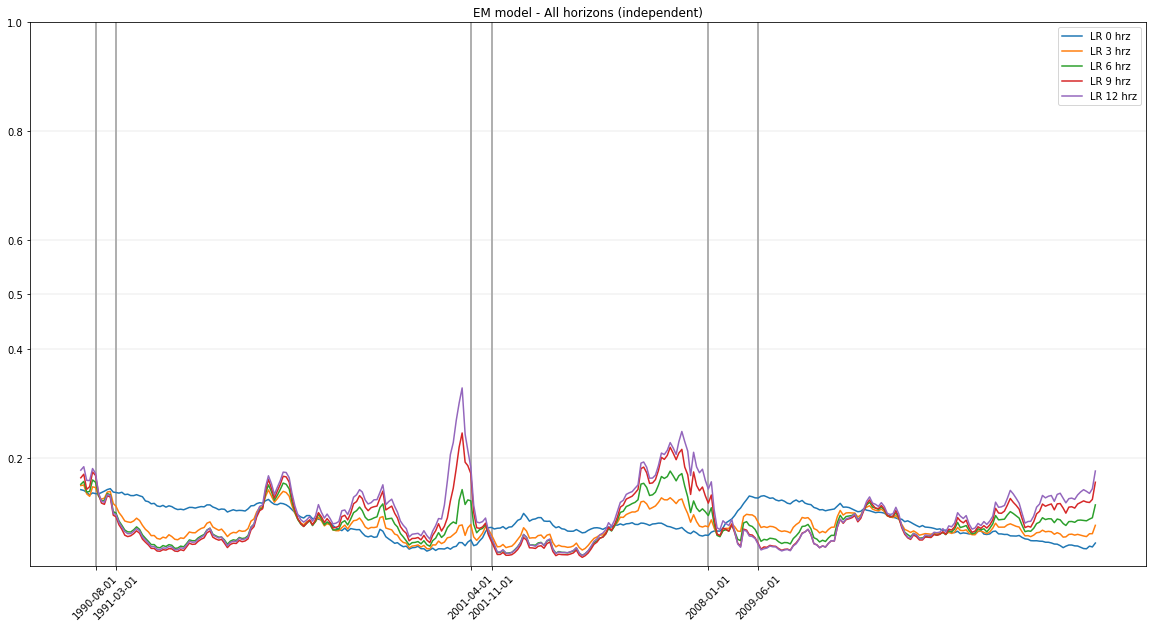

In [76]:
#Plotting
testdates_m_all_em = pd.date_range(start = "1990-02-01",
                          end = "2019-01-01",
                         freq = 'M')

plt.figure(figsize=(20,10))
plt.plot(testdates_m_all_em, pred_proba_lst_0, label = 'LR 0 hrz')
plt.plot(testdates_m_all_em, pred_proba_lst_3, label = 'LR 3 hrz')
plt.plot(testdates_m_all_em, pred_proba_lst_6, label = 'LR 6 hrz')
plt.plot(testdates_m_all_em, pred_proba_lst_9, label = 'LR 9 hrz')
plt.plot(testdates_m_all_em, pred_proba_lst_12, label = 'LR 12 hrz')

plt.xticks(ticks = recession_dates_time, labels = recession_dates, rotation = 45)
plt.yticks(ticks = [0.2, 0.4, 0.5, 0.6, 0.8, 1])


plt.title('EM model - All horizons (independent)')
plt.grid(linewidth = 2, axis = 'x')
plt.grid(linestyle = '-', linewidth = 0.25, axis = 'y')
plt.legend()
plt.savefig('EM model - All horizons (independent).png')
plt.show()

Lowering the threshold to 0.2 would definitely improve the prediction power of the EM model, however even by doing that it's clear that the first recession wuld be missed and that only the 9 hrz and 12 hrz prediction would actually produce a recession prediction. Besides having such little leaway between a recession prediction and a growth one would not be great to begin with

# EM model benchmark ChainClassifier

In [49]:
y_m_chain_em = df_m[m_hrz_lst]
y_m_chain_em = y_m.dropna()
x_m_chain_em = df_m[['10Y-3M','R_S&P500']]
x_m_chain_em = x_m_chain_em[:y_m_chain_em.shape[0]]

n_splits = len(x_m_chain_em)-2
#Number of train/cv/test folds
#58 or 57 is the number for annual splits more or less

trainTestSplit = TimeSeriesSplit(n_splits+1).split(x_m_chain_em)
for i in range(28*12):
    next(trainTestSplit)#Skip the first fold

predicted_m_chain_em = np.array([])
pred_proba_m_chain_em = np.array([])

for trainCvIndices, testIndices in trainTestSplit:
    # First, we split Train + CV and Test
    XTrainCv, yTrainCv = x_m_chain_em.iloc[trainCvIndices,0:], y_m_chain_em.iloc[trainCvIndices,0:]
    XTest, yTest       = x_m_chain_em.iloc[testIndices,0:]   , y_m_chain_em.iloc[testIndices,0:]
    
    # Then, we build a list of the form [ ( [...Train Indices...], [...CV Indices...]  )]
    testLength = len(XTest)
    
    #Model construction and wrapper
    #Need to use list(em) becasue not possible to pickle generators
    model_m_chain_em = LogisticRegression(
            solver = 'saga',
            max_iter = 10000,
            tol = 1e-3,
            n_jobs = -1,
            fit_intercept = True)
    wrapper = ClassifierChain(model_m_chain_em)
    wrapper.fit(XTrainCv, yTrainCv)
    
    #Probabilities and predictions
    ypredicted_m_chain_em = wrapper.predict(XTest)
    ypred_proba_m_chain_em =  wrapper.predict_proba(XTest)
    predicted_m_chain_em = np.append(predicted_m_chain_em, ypredicted_m_chain_em)
    pred_proba_m_chain_em = np.append(pred_proba_m_chain_em, ypred_proba_m_chain_em)
    
    # Printing date ranges
    print("Training:"           , XTrainCv.index[0].date(), "--", XTrainCv.index[-testLength-1].date(),
          ", Cv:"     , XTrainCv.index[-testLength].date(), "--", XTrainCv.index[-1].date(),
          ", Test:"                , XTest.index[0].date(), "--", XTest.index[-1].date())

Training: 1962-01-01 -- 1989-12-01 , Cv: 1990-01-01 -- 1990-01-01 , Test: 1990-02-01 -- 1990-02-01
Training: 1962-01-01 -- 1990-01-01 , Cv: 1990-02-01 -- 1990-02-01 , Test: 1990-03-01 -- 1990-03-01
Training: 1962-01-01 -- 1990-02-01 , Cv: 1990-03-01 -- 1990-03-01 , Test: 1990-04-01 -- 1990-04-01
Training: 1962-01-01 -- 1990-03-01 , Cv: 1990-04-01 -- 1990-04-01 , Test: 1990-05-01 -- 1990-05-01
Training: 1962-01-01 -- 1990-04-01 , Cv: 1990-05-01 -- 1990-05-01 , Test: 1990-06-01 -- 1990-06-01
Training: 1962-01-01 -- 1990-05-01 , Cv: 1990-06-01 -- 1990-06-01 , Test: 1990-07-01 -- 1990-07-01
Training: 1962-01-01 -- 1990-06-01 , Cv: 1990-07-01 -- 1990-07-01 , Test: 1990-08-01 -- 1990-08-01
Training: 1962-01-01 -- 1990-07-01 , Cv: 1990-08-01 -- 1990-08-01 , Test: 1990-09-01 -- 1990-09-01
Training: 1962-01-01 -- 1990-08-01 , Cv: 1990-09-01 -- 1990-09-01 , Test: 1990-10-01 -- 1990-10-01
Training: 1962-01-01 -- 1990-09-01 , Cv: 1990-10-01 -- 1990-10-01 , Test: 1990-11-01 -- 1990-11-01
Training: 

Training: 1962-01-01 -- 1996-11-01 , Cv: 1996-12-01 -- 1996-12-01 , Test: 1997-01-01 -- 1997-01-01
Training: 1962-01-01 -- 1996-12-01 , Cv: 1997-01-01 -- 1997-01-01 , Test: 1997-02-01 -- 1997-02-01
Training: 1962-01-01 -- 1997-01-01 , Cv: 1997-02-01 -- 1997-02-01 , Test: 1997-03-01 -- 1997-03-01
Training: 1962-01-01 -- 1997-02-01 , Cv: 1997-03-01 -- 1997-03-01 , Test: 1997-04-01 -- 1997-04-01
Training: 1962-01-01 -- 1997-03-01 , Cv: 1997-04-01 -- 1997-04-01 , Test: 1997-05-01 -- 1997-05-01
Training: 1962-01-01 -- 1997-04-01 , Cv: 1997-05-01 -- 1997-05-01 , Test: 1997-06-01 -- 1997-06-01
Training: 1962-01-01 -- 1997-05-01 , Cv: 1997-06-01 -- 1997-06-01 , Test: 1997-07-01 -- 1997-07-01
Training: 1962-01-01 -- 1997-06-01 , Cv: 1997-07-01 -- 1997-07-01 , Test: 1997-08-01 -- 1997-08-01
Training: 1962-01-01 -- 1997-07-01 , Cv: 1997-08-01 -- 1997-08-01 , Test: 1997-09-01 -- 1997-09-01
Training: 1962-01-01 -- 1997-08-01 , Cv: 1997-09-01 -- 1997-09-01 , Test: 1997-10-01 -- 1997-10-01
Training: 

Training: 1962-01-01 -- 2003-10-01 , Cv: 2003-11-01 -- 2003-11-01 , Test: 2003-12-01 -- 2003-12-01
Training: 1962-01-01 -- 2003-11-01 , Cv: 2003-12-01 -- 2003-12-01 , Test: 2004-01-01 -- 2004-01-01
Training: 1962-01-01 -- 2003-12-01 , Cv: 2004-01-01 -- 2004-01-01 , Test: 2004-02-01 -- 2004-02-01
Training: 1962-01-01 -- 2004-01-01 , Cv: 2004-02-01 -- 2004-02-01 , Test: 2004-03-01 -- 2004-03-01
Training: 1962-01-01 -- 2004-02-01 , Cv: 2004-03-01 -- 2004-03-01 , Test: 2004-04-01 -- 2004-04-01
Training: 1962-01-01 -- 2004-03-01 , Cv: 2004-04-01 -- 2004-04-01 , Test: 2004-05-01 -- 2004-05-01
Training: 1962-01-01 -- 2004-04-01 , Cv: 2004-05-01 -- 2004-05-01 , Test: 2004-06-01 -- 2004-06-01
Training: 1962-01-01 -- 2004-05-01 , Cv: 2004-06-01 -- 2004-06-01 , Test: 2004-07-01 -- 2004-07-01
Training: 1962-01-01 -- 2004-06-01 , Cv: 2004-07-01 -- 2004-07-01 , Test: 2004-08-01 -- 2004-08-01
Training: 1962-01-01 -- 2004-07-01 , Cv: 2004-08-01 -- 2004-08-01 , Test: 2004-09-01 -- 2004-09-01
Training: 

Training: 1962-01-01 -- 2010-09-01 , Cv: 2010-10-01 -- 2010-10-01 , Test: 2010-11-01 -- 2010-11-01
Training: 1962-01-01 -- 2010-10-01 , Cv: 2010-11-01 -- 2010-11-01 , Test: 2010-12-01 -- 2010-12-01
Training: 1962-01-01 -- 2010-11-01 , Cv: 2010-12-01 -- 2010-12-01 , Test: 2011-01-01 -- 2011-01-01
Training: 1962-01-01 -- 2010-12-01 , Cv: 2011-01-01 -- 2011-01-01 , Test: 2011-02-01 -- 2011-02-01
Training: 1962-01-01 -- 2011-01-01 , Cv: 2011-02-01 -- 2011-02-01 , Test: 2011-03-01 -- 2011-03-01
Training: 1962-01-01 -- 2011-02-01 , Cv: 2011-03-01 -- 2011-03-01 , Test: 2011-04-01 -- 2011-04-01
Training: 1962-01-01 -- 2011-03-01 , Cv: 2011-04-01 -- 2011-04-01 , Test: 2011-05-01 -- 2011-05-01
Training: 1962-01-01 -- 2011-04-01 , Cv: 2011-05-01 -- 2011-05-01 , Test: 2011-06-01 -- 2011-06-01
Training: 1962-01-01 -- 2011-05-01 , Cv: 2011-06-01 -- 2011-06-01 , Test: 2011-07-01 -- 2011-07-01
Training: 1962-01-01 -- 2011-06-01 , Cv: 2011-07-01 -- 2011-07-01 , Test: 2011-08-01 -- 2011-08-01
Training: 

Training: 1962-01-01 -- 2017-08-01 , Cv: 2017-09-01 -- 2017-09-01 , Test: 2017-10-01 -- 2017-10-01
Training: 1962-01-01 -- 2017-09-01 , Cv: 2017-10-01 -- 2017-10-01 , Test: 2017-11-01 -- 2017-11-01
Training: 1962-01-01 -- 2017-10-01 , Cv: 2017-11-01 -- 2017-11-01 , Test: 2017-12-01 -- 2017-12-01
Training: 1962-01-01 -- 2017-11-01 , Cv: 2017-12-01 -- 2017-12-01 , Test: 2018-01-01 -- 2018-01-01
Training: 1962-01-01 -- 2017-12-01 , Cv: 2018-01-01 -- 2018-01-01 , Test: 2018-02-01 -- 2018-02-01
Training: 1962-01-01 -- 2018-01-01 , Cv: 2018-02-01 -- 2018-02-01 , Test: 2018-03-01 -- 2018-03-01
Training: 1962-01-01 -- 2018-02-01 , Cv: 2018-03-01 -- 2018-03-01 , Test: 2018-04-01 -- 2018-04-01
Training: 1962-01-01 -- 2018-03-01 , Cv: 2018-04-01 -- 2018-04-01 , Test: 2018-05-01 -- 2018-05-01
Training: 1962-01-01 -- 2018-04-01 , Cv: 2018-05-01 -- 2018-05-01 , Test: 2018-06-01 -- 2018-06-01
Training: 1962-01-01 -- 2018-05-01 , Cv: 2018-06-01 -- 2018-06-01 , Test: 2018-07-01 -- 2018-07-01
Training: 

In [73]:
#Uncomment below when needed
# pred_proba_m_chain_em = pred_proba_m_chain_em.tolist()
# predicted_m_chain_em = predicted_m_chain_em.tolist()

pred_proba_lst_0 = pred_proba_m_chain_em[0::6]
predicted_lst_0 = predicted_m_chain_em[0::6]
yTest_m0 = df_m['USREC']['1990-02-01':'2018-12-01']
errors_0 = error_metrics(pred_proba_lst_0, predicted_lst_0, yTest_m0)

pred_proba_lst_1 = pred_proba_m_chain_em[1::6]
predicted_lst_1 = predicted_m_chain_em[1::6]
yTest_m1 = df_m['USREC+1']['1990-02-01':'2018-12-01']
errors_1 = error_metrics(pred_proba_lst_1, predicted_lst_1, yTest_m1)

pred_proba_lst_3 = pred_proba_m_chain_em[2::6]
predicted_lst_3 = predicted_m_chain_em[2::6]
yTest_m3 = df_m['USREC+3']['1990-02-01':'2018-12-01']
errors_3 = error_metrics(pred_proba_lst_3, predicted_lst_3, yTest_m3)

pred_proba_lst_6 = pred_proba_m_chain_em[3::6]
predicted_lst_6 = predicted_m_chain_em[3::6]
yTest_m6 = df_m['USREC+6']['1990-02-01':'2018-12-01']
errors_6 = error_metrics(pred_proba_lst_6, predicted_lst_6, yTest_m6)

pred_proba_lst_9 = pred_proba_m_chain_em[4::6]
predicted_lst_9 = predicted_m_chain_em[4::6]
yTest_m9 = df_m['USREC+9']['1990-02-01':'2018-12-01']
errors_9 = error_metrics(pred_proba_lst_9, predicted_lst_9, yTest_m9)

pred_proba_lst_12 = pred_proba_m_chain_em[5::6]
predicted_lst_12 = predicted_m_chain_em[5::6] 
yTest_m12 = df_m['USREC+12']['1990-02-01':'2018-12-01']
errors_12 = error_metrics(pred_proba_lst_12, predicted_lst_12, yTest_m12)
errors_em_chain = pd.DataFrame(data = [errors_0,
                                        errors_3,
                                        errors_6,
                                        errors_9,
                                        errors_12],
                                 index = ['hrz_0',
                                         'hrz_3',
                                         'hrz_6',
                                         'hrz_9',
                                         'hrz_12'],
                                columns = ['QPS', 'LogLoss', 'Accuracy',
                                           'Sensitivity', 'False Positives', 
                                           'False Negatives'])


errors_em_chain

,QPS,LogLoss,Accuracy,Sensitivity,False Positives,False Negatives
hrz_0,0.172985,0.311089,0.902017,0.0,0,34
hrz_3,0.185847,0.372080,0.902017,0.0,0,34
hrz_6,0.178769,0.328429,0.902017,0.0,0,34
hrz_9,0.158290,0.282216,0.910663,0.0,0,31
hrz_12,0.141645,0.253210,0.919308,0.0,0,28


The chainclassifier does not seem to provide additional accuracy and there is a strong efficiency tradeoff (much slower calculation)

# Survey of professional forecasters

In [51]:
df_spf = pd.read_csv('Mean_RECESS_Level.csv')
df_spf.index = pd.date_range(start = "1968-10-01",
                          end = "2020-07-01",
                         freq = 'Q')
df_spf = df_spf.drop(columns = ['YEAR', 'QUARTER', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'])
df_spf = df_spf['1990-02-01':'2019-01-01']
df_spf = df_spf/100
df_spf

,RECESS1,RECESS2,RECESS3,RECESS4,RECESS5
1990-03-31,0.2036,0.2250,0.1693,0.1643,0.1771
1990-06-30,0.1143,0.1786,0.3071,0.2643,0.2000
1990-09-30,0.2846,0.4154,0.3654,0.3000,0.2231
1990-12-31,0.7113,0.7000,0.5450,0.3417,0.2133
1991-03-31,0.8638,0.6059,0.3397,0.1912,0.1294
...,...,...,...,...,...
2017-12-31,0.0629,0.1044,0.1264,0.1469,0.1705
2018-03-31,0.0581,0.0908,0.1143,0.1360,0.1678
2018-06-30,0.0533,0.0859,0.1108,0.1441,0.1564
2018-09-30,0.0655,0.1053,0.1323,0.1641,0.1963


In [52]:
df_rec_q = pd.read_csv('USREC.csv')
df_rec_q = df_rec_q[1:]
df_rec_q.index = pd.date_range(start = '1990-02-01',
                          end = '2019-01-01',
                         freq = 'Q')
df_rec_q = df_rec_q['USREC']
df_rec_q

1990-03-31    0
1990-06-30    1
1990-09-30    1
1990-12-31    1
1991-03-31    0
             ..
2017-12-31    0
2018-03-31    0
2018-06-30    0
2018-09-30    0
2018-12-31    0
Freq: Q-DEC, Name: USREC, Length: 116, dtype: int64

In [83]:
pred_proba_lst_0 = df_spf['RECESS1']
predicted_lst_0 = []
for i in range(len(pred_proba_lst_0)):
    if pred_proba_lst_0[i] >= 0.5:
        predicted_lst_0.append(1)
    else:
        predicted_lst_0.append(0)

errors_0 = error_metrics(pred_proba_lst_0, predicted_lst_0, df_rec_q)

pred_proba_lst_6 = df_spf['RECESS2']
predicted_lst_3 = []
for i in range(len(pred_proba_lst_3)):
    if pred_proba_lst_3[i] >= 0.5:
        predicted_lst_3.append(1)
    else:
        predicted_lst_3.append(0)

errors_3 = error_metrics(pred_proba_lst_3, predicted_lst_3, df_rec_q)

pred_proba_lst_6 = df_spf['RECESS3']
predicted_lst_6 = []
for i in range(len(pred_proba_lst_6)):
    if pred_proba_lst_6[i] >= 0.5:
        predicted_lst_6.append(1)
    else:
        predicted_lst_6.append(0)

errors_6 = error_metrics(pred_proba_lst_6, predicted_lst_6, df_rec_q)

pred_proba_lst_9 = df_spf['RECESS4']
predicted_lst_9 = []
for i in range(len(pred_proba_lst_9)):
    if pred_proba_lst_9[i] >= 0.5:
        predicted_lst_9.append(1)
    else:
        predicted_lst_9.append(0)

errors_9 = error_metrics(pred_proba_lst_9, predicted_lst_9, df_rec_q)

pred_proba_lst_12 = df_spf['RECESS5']
predicted_lst_12 = []
for i in range(len(pred_proba_lst_12)):
    if pred_proba_lst_12[i] >= 0.5:
        predicted_lst_12.append(1)
    else:
        predicted_lst_12.append(0)

errors_12 = error_metrics(pred_proba_lst_12, predicted_lst_12, df_rec_q)

errors_spf = pd.DataFrame(data = [errors_0,
                                        errors_3,
                                        errors_6,
                                        errors_9,
                                        errors_12],
                                index = ['hrz_0',
                                         'hrz_3',
                                         'hrz_6',
                                         'hrz_9',
                                         'hrz_12'],
                                columns = ['QPS', 'LogLoss', 'Accuracy',
                                           'Sensitivity', 'False Positives', 
                                           'False Negatives'])


errors_spf

,QPS,LogLoss,Accuracy,Sensitivity,False Positives,False Negatives
hrz_0,0.135475,0.235617,0.896552,0.272727,4,8
hrz_3,0.114391,0.225481,0.922414,0.272727,1,8
hrz_6,0.123611,0.244609,0.913793,0.090909,0,10
hrz_9,0.148526,0.279307,0.905172,0.000000,0,11
hrz_12,0.171475,0.314259,0.905172,0.000000,0,11


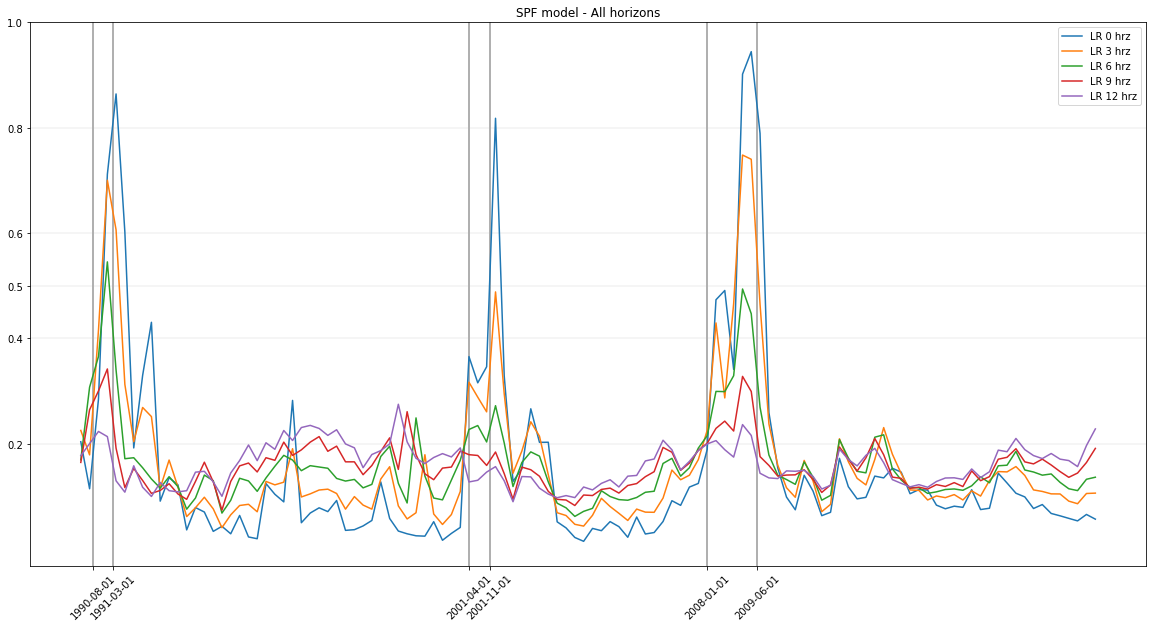

In [88]:
#Plotting
testdates_m_all_em = pd.date_range(start = "1990-02-01",
                          end = "2019-01-01",
                         freq = 'Q')

plt.figure(figsize=(20,10))
plt.plot(testdates_m_all_em, pred_proba_lst_0, label = 'LR 0 hrz')
plt.plot(testdates_m_all_em, pred_proba_lst_3, label = 'LR 3 hrz')
plt.plot(testdates_m_all_em, pred_proba_lst_6, label = 'LR 6 hrz')
plt.plot(testdates_m_all_em, pred_proba_lst_9, label = 'LR 9 hrz')
plt.plot(testdates_m_all_em, pred_proba_lst_12, label = 'LR 12 hrz')

plt.xticks(ticks = recession_dates_time, labels = recession_dates, rotation = 45)
plt.yticks(ticks = [0.2, 0.4, 0.5, 0.6, 0.8, 1])


plt.title('SPF model - All horizons')
plt.grid(linewidth = 2, axis = 'x')
plt.grid(linestyle = '-', linewidth = 0.25, axis = 'y')
plt.legend()
plt.savefig('SPF model - All horizons.png')
plt.show()

In [54]:
errors_tscv_all

,QPS,LogLoss,Accuracy,Sensitivity,False Positives,False Negatives
hrz_0,0.056963,0.109837,0.959654,0.647059,2,12
hrz_3,0.102512,0.203227,0.933718,0.500000,6,17
hrz_6,0.121361,0.226909,0.925072,0.235294,0,26
hrz_9,0.117690,0.183779,0.916427,0.096774,1,28
hrz_12,0.108121,0.178051,0.927954,0.250000,4,21


The QPS and LogLoss across all horizons is better than the SPF ones.

# Coefficients

In [99]:
model_m_all_tscv_L2.fit(x_m, y_m['USREC'])
# list(model_q_chain_tscv.coef_)
# list(x_q.columns)

coeff_df = pd.DataFrame(model_m_all_tscv_L2.coef_.transpose() , index = x_m.columns, columns = ['Coefficient'])
coeff_df

,Coefficient
GS10,0.293614
TB3MS,0.351066
GS1,0.328259
AAA10YM,1.077953
DTB6,0.227050
BAA10YM,0.770681
FEDFUNDS,0.697304
WPU102301,0.339769
WPU101,-0.054266
BOGMBASE,-0.468109
